In [1]:
from __future__ import print_function

### VGP notebook 4 LSTM Gradients check

In [2]:
# Load data and imports
import numpy as np
from numpy import array, asarray, zeros
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
#tf.enable_eager_execution()
from keras import Input, Model
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import BatchNormalization, PReLU
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import RNN, LSTMCell, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping, LambdaCallback, TensorBoard

# Hyperas for hyperparameter selection
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from keras import backend as k
#tf.compat.v1.disable_eager_execution()
import os 

In [3]:
def data_pp():
    train= pd.read_csv('/Users/necromancerchenmy/Desktop/honours_thesis/thesis/thesis_proposal/NLP tutorial/Toxic comment data/jigsaw-toxic-comment-train.csv')
    train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)
    train= train.iloc[:50000,:]
    xtr, xte, ytr, yte= train_test_split(train['comment_text'].values, 
                                        train['toxic'].values,
                                        stratify= train['toxic'].values,
                                        random_state= 42, test_size= 0.2, shuffle= True)
    
    # Tokenise data
    tok= text.Tokenizer(num_words= None)
    tok.fit_on_texts(list(xtr)+ list(xte))
    input_dim= len(tok.word_index)+1
    input_length= train['comment_text'].apply(lambda x: len(str(x).split())).max()
    xtr_seq= tok.texts_to_sequences(xtr); xte_seq= tok.texts_to_sequences(xte)
    xtr_pad= sequence.pad_sequences(xtr_seq, maxlen= input_length)
    xte_pad= sequence.pad_sequences(xte_seq, maxlen= input_length)
    print('Shape of tokenised training input:', xtr_pad.shape)
    return xtr_pad, ytr, xte_pad, yte, input_dim, input_length, tok
    
xtr_pad, ytr, xte_pad, yte, input_dim, input_length, tok= data_pp()

# Word embeddings
def embed_mat(input_dim, output_dim, tok):
    '''By default output_dim = 100 for GloVe 100d embeddings'''
    embedding_dict=dict()
    f= open('/Users/necromancerchenmy/Desktop/honours_thesis/thesis/thesis_proposal/NLP tutorial/GloVe/glove.6B.100d.txt')
    for line in f:
        values= line.split()
        word= values[0]; coefs= asarray(values[1:], dtype= 'float32')
        embedding_dict[word]= coefs
    f.close()
    Emat= zeros((input_dim, output_dim))
    for word, i in tok.word_index.items():
        embedding_vector= embedding_dict.get(word)
        if embedding_vector is not None:
            Emat[i]= embedding_vector
    print('Embedding weight matrix has shape:', Emat.shape)
    return Emat

output_dim = 100
Emat= embed_mat(input_dim, output_dim, tok)


Shape of tokenised training input: (40000, 1403)
Embedding weight matrix has shape: (102554, 100)


### 1. VGP check on RNN recap

In [7]:
# Define RNN model
batch_size = 100
inp= Input(batch_shape= (batch_size, input_length), name= 'input') 
emb_out= Embedding(input_dim, output_dim, input_length= input_length, 
                         weights= [Emat], trainable= False, name= 'embedding')(inp)

rnn= SimpleRNN(200, return_sequences= True, return_state= False, stateful= False,
               batch_size= (batch_size, input_length, 100), name= 'simpleRNN')

# Initial hidden states
h0 = tf.Variable(tf.random.uniform((batch_size, 200)))
rnn_allstates= rnn(emb_out, initial_state=h0) 
print(rnn_allstates.shape) 
model_rnn = Model(inputs=inp, outputs= rnn_allstates, name= 'model_rnn')
model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model_rnn.layers


(100, 1403, 200)


In [10]:
ds = tf.data.Dataset.from_tensor_slices((xtr_pad, ytr)).batch(100)

@tf.function
# Compute gradients
def compute_dht_dh0(t, x, h0):
    return tf.gradients(model_rnn(x)[:,t,:], h0)
        
n_b = int(xtr_pad.shape[0]/ 100)  # 400 batches
n_steps = 20   # look up only the first and last 20 steps

dhtdh0_all= tf.zeros([n_b, n_steps])
for b, (x_batch_train, y_batch_train) in enumerate(ds):  # batches 0,1
    grad_batch= []   # a list of 1403 scalar gradients on the current batch
    for t in range(n_steps):  
        # steps 0,...,19
        dhtdh0_b_t = compute_dht_dh0(t, x_batch_train, h0)  # (batch_size, n_units)
        grad_t = tf.reduce_mean(abs(dhtdh0_b_t[0]), [0,1]) # Scalar dctdc0 at the current batch and step
        print('step', t+1, 'of batch' ,b+1, 'done')
        grad_batch.append(grad_t)
    
    dhtdh0_all= tf.concat([dhtdh0_all, [grad_batch]], axis = 0)   

dhtdh0_agg= tf.reduce_mean(dhtdh0_all, 0)  # take rowmean to obtain a vector of shape (20,)
print(dhtdh0_agg.shape)

step 1 of batch 1 done
step 2 of batch 1 done
step 3 of batch 1 done
step 4 of batch 1 done
step 5 of batch 1 done
step 6 of batch 1 done
step 7 of batch 1 done
step 8 of batch 1 done
step 9 of batch 1 done
step 10 of batch 1 done
step 11 of batch 1 done
step 12 of batch 1 done
step 13 of batch 1 done
step 14 of batch 1 done
step 15 of batch 1 done
step 16 of batch 1 done
step 17 of batch 1 done
step 18 of batch 1 done
step 19 of batch 1 done
step 20 of batch 1 done
step 1 of batch 2 done
step 2 of batch 2 done
step 3 of batch 2 done
step 4 of batch 2 done
step 5 of batch 2 done
step 6 of batch 2 done
step 7 of batch 2 done
step 8 of batch 2 done
step 9 of batch 2 done
step 10 of batch 2 done
step 11 of batch 2 done
step 12 of batch 2 done
step 13 of batch 2 done
step 14 of batch 2 done
step 15 of batch 2 done
step 16 of batch 2 done
step 17 of batch 2 done
step 18 of batch 2 done
step 19 of batch 2 done
step 20 of batch 2 done
step 1 of batch 3 done
step 2 of batch 3 done
step 3 of ba

step 6 of batch 15 done
step 7 of batch 15 done
step 8 of batch 15 done
step 9 of batch 15 done
step 10 of batch 15 done
step 11 of batch 15 done
step 12 of batch 15 done
step 13 of batch 15 done
step 14 of batch 15 done
step 15 of batch 15 done
step 16 of batch 15 done
step 17 of batch 15 done
step 18 of batch 15 done
step 19 of batch 15 done
step 20 of batch 15 done
step 1 of batch 16 done
step 2 of batch 16 done
step 3 of batch 16 done
step 4 of batch 16 done
step 5 of batch 16 done
step 6 of batch 16 done
step 7 of batch 16 done
step 8 of batch 16 done
step 9 of batch 16 done
step 10 of batch 16 done
step 11 of batch 16 done
step 12 of batch 16 done
step 13 of batch 16 done
step 14 of batch 16 done
step 15 of batch 16 done
step 16 of batch 16 done
step 17 of batch 16 done
step 18 of batch 16 done
step 19 of batch 16 done
step 20 of batch 16 done
step 1 of batch 17 done
step 2 of batch 17 done
step 3 of batch 17 done
step 4 of batch 17 done
step 5 of batch 17 done
step 6 of batch 17

step 20 of batch 31 done
step 1 of batch 32 done
step 2 of batch 32 done
step 3 of batch 32 done
step 4 of batch 32 done
step 5 of batch 32 done
step 6 of batch 32 done
step 7 of batch 32 done
step 8 of batch 32 done
step 9 of batch 32 done
step 10 of batch 32 done
step 11 of batch 32 done
step 12 of batch 32 done
step 13 of batch 32 done
step 14 of batch 32 done
step 15 of batch 32 done
step 16 of batch 32 done
step 17 of batch 32 done
step 18 of batch 32 done
step 19 of batch 32 done
step 20 of batch 32 done
step 1 of batch 33 done
step 2 of batch 33 done
step 3 of batch 33 done
step 4 of batch 33 done
step 5 of batch 33 done
step 6 of batch 33 done
step 7 of batch 33 done
step 8 of batch 33 done
step 9 of batch 33 done
step 10 of batch 33 done
step 11 of batch 33 done
step 12 of batch 33 done
step 13 of batch 33 done
step 14 of batch 33 done
step 15 of batch 33 done
step 16 of batch 33 done
step 17 of batch 33 done
step 18 of batch 33 done
step 19 of batch 33 done
step 20 of batch 3

step 14 of batch 48 done
step 15 of batch 48 done
step 16 of batch 48 done
step 17 of batch 48 done
step 18 of batch 48 done
step 19 of batch 48 done
step 20 of batch 48 done
step 1 of batch 49 done
step 2 of batch 49 done
step 3 of batch 49 done
step 4 of batch 49 done
step 5 of batch 49 done
step 6 of batch 49 done
step 7 of batch 49 done
step 8 of batch 49 done
step 9 of batch 49 done
step 10 of batch 49 done
step 11 of batch 49 done
step 12 of batch 49 done
step 13 of batch 49 done
step 14 of batch 49 done
step 15 of batch 49 done
step 16 of batch 49 done
step 17 of batch 49 done
step 18 of batch 49 done
step 19 of batch 49 done
step 20 of batch 49 done
step 1 of batch 50 done
step 2 of batch 50 done
step 3 of batch 50 done
step 4 of batch 50 done
step 5 of batch 50 done
step 6 of batch 50 done
step 7 of batch 50 done
step 8 of batch 50 done
step 9 of batch 50 done
step 10 of batch 50 done
step 11 of batch 50 done
step 12 of batch 50 done
step 13 of batch 50 done
step 14 of batch 5

step 8 of batch 65 done
step 9 of batch 65 done
step 10 of batch 65 done
step 11 of batch 65 done
step 12 of batch 65 done
step 13 of batch 65 done
step 14 of batch 65 done
step 15 of batch 65 done
step 16 of batch 65 done
step 17 of batch 65 done
step 18 of batch 65 done
step 19 of batch 65 done
step 20 of batch 65 done
step 1 of batch 66 done
step 2 of batch 66 done
step 3 of batch 66 done
step 4 of batch 66 done
step 5 of batch 66 done
step 6 of batch 66 done
step 7 of batch 66 done
step 8 of batch 66 done
step 9 of batch 66 done
step 10 of batch 66 done
step 11 of batch 66 done
step 12 of batch 66 done
step 13 of batch 66 done
step 14 of batch 66 done
step 15 of batch 66 done
step 16 of batch 66 done
step 17 of batch 66 done
step 18 of batch 66 done
step 19 of batch 66 done
step 20 of batch 66 done
step 1 of batch 67 done
step 2 of batch 67 done
step 3 of batch 67 done
step 4 of batch 67 done
step 5 of batch 67 done
step 6 of batch 67 done
step 7 of batch 67 done
step 8 of batch 67

step 2 of batch 82 done
step 3 of batch 82 done
step 4 of batch 82 done
step 5 of batch 82 done
step 6 of batch 82 done
step 7 of batch 82 done
step 8 of batch 82 done
step 9 of batch 82 done
step 10 of batch 82 done
step 11 of batch 82 done
step 12 of batch 82 done
step 13 of batch 82 done
step 14 of batch 82 done
step 15 of batch 82 done
step 16 of batch 82 done
step 17 of batch 82 done
step 18 of batch 82 done
step 19 of batch 82 done
step 20 of batch 82 done
step 1 of batch 83 done
step 2 of batch 83 done
step 3 of batch 83 done
step 4 of batch 83 done
step 5 of batch 83 done
step 6 of batch 83 done
step 7 of batch 83 done
step 8 of batch 83 done
step 9 of batch 83 done
step 10 of batch 83 done
step 11 of batch 83 done
step 12 of batch 83 done
step 13 of batch 83 done
step 14 of batch 83 done
step 15 of batch 83 done
step 16 of batch 83 done
step 17 of batch 83 done
step 18 of batch 83 done
step 19 of batch 83 done
step 20 of batch 83 done
step 1 of batch 84 done
step 2 of batch 84

step 16 of batch 98 done
step 17 of batch 98 done
step 18 of batch 98 done
step 19 of batch 98 done
step 20 of batch 98 done
step 1 of batch 99 done
step 2 of batch 99 done
step 3 of batch 99 done
step 4 of batch 99 done
step 5 of batch 99 done
step 6 of batch 99 done
step 7 of batch 99 done
step 8 of batch 99 done
step 9 of batch 99 done
step 10 of batch 99 done
step 11 of batch 99 done
step 12 of batch 99 done
step 13 of batch 99 done
step 14 of batch 99 done
step 15 of batch 99 done
step 16 of batch 99 done
step 17 of batch 99 done
step 18 of batch 99 done
step 19 of batch 99 done
step 20 of batch 99 done
step 1 of batch 100 done
step 2 of batch 100 done
step 3 of batch 100 done
step 4 of batch 100 done
step 5 of batch 100 done
step 6 of batch 100 done
step 7 of batch 100 done
step 8 of batch 100 done
step 9 of batch 100 done
step 10 of batch 100 done
step 11 of batch 100 done
step 12 of batch 100 done
step 13 of batch 100 done
step 14 of batch 100 done
step 15 of batch 100 done
ste

step 18 of batch 114 done
step 19 of batch 114 done
step 20 of batch 114 done
step 1 of batch 115 done
step 2 of batch 115 done
step 3 of batch 115 done
step 4 of batch 115 done
step 5 of batch 115 done
step 6 of batch 115 done
step 7 of batch 115 done
step 8 of batch 115 done
step 9 of batch 115 done
step 10 of batch 115 done
step 11 of batch 115 done
step 12 of batch 115 done
step 13 of batch 115 done
step 14 of batch 115 done
step 15 of batch 115 done
step 16 of batch 115 done
step 17 of batch 115 done
step 18 of batch 115 done
step 19 of batch 115 done
step 20 of batch 115 done
step 1 of batch 116 done
step 2 of batch 116 done
step 3 of batch 116 done
step 4 of batch 116 done
step 5 of batch 116 done
step 6 of batch 116 done
step 7 of batch 116 done
step 8 of batch 116 done
step 9 of batch 116 done
step 10 of batch 116 done
step 11 of batch 116 done
step 12 of batch 116 done
step 13 of batch 116 done
step 14 of batch 116 done
step 15 of batch 116 done
step 16 of batch 116 done
step

step 19 of batch 130 done
step 20 of batch 130 done
step 1 of batch 131 done
step 2 of batch 131 done
step 3 of batch 131 done
step 4 of batch 131 done
step 5 of batch 131 done
step 6 of batch 131 done
step 7 of batch 131 done
step 8 of batch 131 done
step 9 of batch 131 done
step 10 of batch 131 done
step 11 of batch 131 done
step 12 of batch 131 done
step 13 of batch 131 done
step 14 of batch 131 done
step 15 of batch 131 done
step 16 of batch 131 done
step 17 of batch 131 done
step 18 of batch 131 done
step 19 of batch 131 done
step 20 of batch 131 done
step 1 of batch 132 done
step 2 of batch 132 done
step 3 of batch 132 done
step 4 of batch 132 done
step 5 of batch 132 done
step 6 of batch 132 done
step 7 of batch 132 done
step 8 of batch 132 done
step 9 of batch 132 done
step 10 of batch 132 done
step 11 of batch 132 done
step 12 of batch 132 done
step 13 of batch 132 done
step 14 of batch 132 done
step 15 of batch 132 done
step 16 of batch 132 done
step 17 of batch 132 done
step

step 20 of batch 146 done
step 1 of batch 147 done
step 2 of batch 147 done
step 3 of batch 147 done
step 4 of batch 147 done
step 5 of batch 147 done
step 6 of batch 147 done
step 7 of batch 147 done
step 8 of batch 147 done
step 9 of batch 147 done
step 10 of batch 147 done
step 11 of batch 147 done
step 12 of batch 147 done
step 13 of batch 147 done
step 14 of batch 147 done
step 15 of batch 147 done
step 16 of batch 147 done
step 17 of batch 147 done
step 18 of batch 147 done
step 19 of batch 147 done
step 20 of batch 147 done
step 1 of batch 148 done
step 2 of batch 148 done
step 3 of batch 148 done
step 4 of batch 148 done
step 5 of batch 148 done
step 6 of batch 148 done
step 7 of batch 148 done
step 8 of batch 148 done
step 9 of batch 148 done
step 10 of batch 148 done
step 11 of batch 148 done
step 12 of batch 148 done
step 13 of batch 148 done
step 14 of batch 148 done
step 15 of batch 148 done
step 16 of batch 148 done
step 17 of batch 148 done
step 18 of batch 148 done
step

step 1 of batch 163 done
step 2 of batch 163 done
step 3 of batch 163 done
step 4 of batch 163 done
step 5 of batch 163 done
step 6 of batch 163 done
step 7 of batch 163 done
step 8 of batch 163 done
step 9 of batch 163 done
step 10 of batch 163 done
step 11 of batch 163 done
step 12 of batch 163 done
step 13 of batch 163 done
step 14 of batch 163 done
step 15 of batch 163 done
step 16 of batch 163 done
step 17 of batch 163 done
step 18 of batch 163 done
step 19 of batch 163 done
step 20 of batch 163 done
step 1 of batch 164 done
step 2 of batch 164 done
step 3 of batch 164 done
step 4 of batch 164 done
step 5 of batch 164 done
step 6 of batch 164 done
step 7 of batch 164 done
step 8 of batch 164 done
step 9 of batch 164 done
step 10 of batch 164 done
step 11 of batch 164 done
step 12 of batch 164 done
step 13 of batch 164 done
step 14 of batch 164 done
step 15 of batch 164 done
step 16 of batch 164 done
step 17 of batch 164 done
step 18 of batch 164 done
step 19 of batch 164 done
step

step 2 of batch 179 done
step 3 of batch 179 done
step 4 of batch 179 done
step 5 of batch 179 done
step 6 of batch 179 done
step 7 of batch 179 done
step 8 of batch 179 done
step 9 of batch 179 done
step 10 of batch 179 done
step 11 of batch 179 done
step 12 of batch 179 done
step 13 of batch 179 done
step 14 of batch 179 done
step 15 of batch 179 done
step 16 of batch 179 done
step 17 of batch 179 done
step 18 of batch 179 done
step 19 of batch 179 done
step 20 of batch 179 done
step 1 of batch 180 done
step 2 of batch 180 done
step 3 of batch 180 done
step 4 of batch 180 done
step 5 of batch 180 done
step 6 of batch 180 done
step 7 of batch 180 done
step 8 of batch 180 done
step 9 of batch 180 done
step 10 of batch 180 done
step 11 of batch 180 done
step 12 of batch 180 done
step 13 of batch 180 done
step 14 of batch 180 done
step 15 of batch 180 done
step 16 of batch 180 done
step 17 of batch 180 done
step 18 of batch 180 done
step 19 of batch 180 done
step 20 of batch 180 done
ste

step 3 of batch 195 done
step 4 of batch 195 done
step 5 of batch 195 done
step 6 of batch 195 done
step 7 of batch 195 done
step 8 of batch 195 done
step 9 of batch 195 done
step 10 of batch 195 done
step 11 of batch 195 done
step 12 of batch 195 done
step 13 of batch 195 done
step 14 of batch 195 done
step 15 of batch 195 done
step 16 of batch 195 done
step 17 of batch 195 done
step 18 of batch 195 done
step 19 of batch 195 done
step 20 of batch 195 done
step 1 of batch 196 done
step 2 of batch 196 done
step 3 of batch 196 done
step 4 of batch 196 done
step 5 of batch 196 done
step 6 of batch 196 done
step 7 of batch 196 done
step 8 of batch 196 done
step 9 of batch 196 done
step 10 of batch 196 done
step 11 of batch 196 done
step 12 of batch 196 done
step 13 of batch 196 done
step 14 of batch 196 done
step 15 of batch 196 done
step 16 of batch 196 done
step 17 of batch 196 done
step 18 of batch 196 done
step 19 of batch 196 done
step 20 of batch 196 done
step 1 of batch 197 done
ste

step 4 of batch 211 done
step 5 of batch 211 done
step 6 of batch 211 done
step 7 of batch 211 done
step 8 of batch 211 done
step 9 of batch 211 done
step 10 of batch 211 done
step 11 of batch 211 done
step 12 of batch 211 done
step 13 of batch 211 done
step 14 of batch 211 done
step 15 of batch 211 done
step 16 of batch 211 done
step 17 of batch 211 done
step 18 of batch 211 done
step 19 of batch 211 done
step 20 of batch 211 done
step 1 of batch 212 done
step 2 of batch 212 done
step 3 of batch 212 done
step 4 of batch 212 done
step 5 of batch 212 done
step 6 of batch 212 done
step 7 of batch 212 done
step 8 of batch 212 done
step 9 of batch 212 done
step 10 of batch 212 done
step 11 of batch 212 done
step 12 of batch 212 done
step 13 of batch 212 done
step 14 of batch 212 done
step 15 of batch 212 done
step 16 of batch 212 done
step 17 of batch 212 done
step 18 of batch 212 done
step 19 of batch 212 done
step 20 of batch 212 done
step 1 of batch 213 done
step 2 of batch 213 done
ste

step 5 of batch 227 done
step 6 of batch 227 done
step 7 of batch 227 done
step 8 of batch 227 done
step 9 of batch 227 done
step 10 of batch 227 done
step 11 of batch 227 done
step 12 of batch 227 done
step 13 of batch 227 done
step 14 of batch 227 done
step 15 of batch 227 done
step 16 of batch 227 done
step 17 of batch 227 done
step 18 of batch 227 done
step 19 of batch 227 done
step 20 of batch 227 done
step 1 of batch 228 done
step 2 of batch 228 done
step 3 of batch 228 done
step 4 of batch 228 done
step 5 of batch 228 done
step 6 of batch 228 done
step 7 of batch 228 done
step 8 of batch 228 done
step 9 of batch 228 done
step 10 of batch 228 done
step 11 of batch 228 done
step 12 of batch 228 done
step 13 of batch 228 done
step 14 of batch 228 done
step 15 of batch 228 done
step 16 of batch 228 done
step 17 of batch 228 done
step 18 of batch 228 done
step 19 of batch 228 done
step 20 of batch 228 done
step 1 of batch 229 done
step 2 of batch 229 done
step 3 of batch 229 done
ste

step 6 of batch 243 done
step 7 of batch 243 done
step 8 of batch 243 done
step 9 of batch 243 done
step 10 of batch 243 done
step 11 of batch 243 done
step 12 of batch 243 done
step 13 of batch 243 done
step 14 of batch 243 done
step 15 of batch 243 done
step 16 of batch 243 done
step 17 of batch 243 done
step 18 of batch 243 done
step 19 of batch 243 done
step 20 of batch 243 done
step 1 of batch 244 done
step 2 of batch 244 done
step 3 of batch 244 done
step 4 of batch 244 done
step 5 of batch 244 done
step 6 of batch 244 done
step 7 of batch 244 done
step 8 of batch 244 done
step 9 of batch 244 done
step 10 of batch 244 done
step 11 of batch 244 done
step 12 of batch 244 done
step 13 of batch 244 done
step 14 of batch 244 done
step 15 of batch 244 done
step 16 of batch 244 done
step 17 of batch 244 done
step 18 of batch 244 done
step 19 of batch 244 done
step 20 of batch 244 done
step 1 of batch 245 done
step 2 of batch 245 done
step 3 of batch 245 done
step 4 of batch 245 done
ste

step 7 of batch 259 done
step 8 of batch 259 done
step 9 of batch 259 done
step 10 of batch 259 done
step 11 of batch 259 done
step 12 of batch 259 done
step 13 of batch 259 done
step 14 of batch 259 done
step 15 of batch 259 done
step 16 of batch 259 done
step 17 of batch 259 done
step 18 of batch 259 done
step 19 of batch 259 done
step 20 of batch 259 done
step 1 of batch 260 done
step 2 of batch 260 done
step 3 of batch 260 done
step 4 of batch 260 done
step 5 of batch 260 done
step 6 of batch 260 done
step 7 of batch 260 done
step 8 of batch 260 done
step 9 of batch 260 done
step 10 of batch 260 done
step 11 of batch 260 done
step 12 of batch 260 done
step 13 of batch 260 done
step 14 of batch 260 done
step 15 of batch 260 done
step 16 of batch 260 done
step 17 of batch 260 done
step 18 of batch 260 done
step 19 of batch 260 done
step 20 of batch 260 done
step 1 of batch 261 done
step 2 of batch 261 done
step 3 of batch 261 done
step 4 of batch 261 done
step 5 of batch 261 done
ste

step 8 of batch 275 done
step 9 of batch 275 done
step 10 of batch 275 done
step 11 of batch 275 done
step 12 of batch 275 done
step 13 of batch 275 done
step 14 of batch 275 done
step 15 of batch 275 done
step 16 of batch 275 done
step 17 of batch 275 done
step 18 of batch 275 done
step 19 of batch 275 done
step 20 of batch 275 done
step 1 of batch 276 done
step 2 of batch 276 done
step 3 of batch 276 done
step 4 of batch 276 done
step 5 of batch 276 done
step 6 of batch 276 done
step 7 of batch 276 done
step 8 of batch 276 done
step 9 of batch 276 done
step 10 of batch 276 done
step 11 of batch 276 done
step 12 of batch 276 done
step 13 of batch 276 done
step 14 of batch 276 done
step 15 of batch 276 done
step 16 of batch 276 done
step 17 of batch 276 done
step 18 of batch 276 done
step 19 of batch 276 done
step 20 of batch 276 done
step 1 of batch 277 done
step 2 of batch 277 done
step 3 of batch 277 done
step 4 of batch 277 done
step 5 of batch 277 done
step 6 of batch 277 done
ste

step 9 of batch 291 done
step 10 of batch 291 done
step 11 of batch 291 done
step 12 of batch 291 done
step 13 of batch 291 done
step 14 of batch 291 done
step 15 of batch 291 done
step 16 of batch 291 done
step 17 of batch 291 done
step 18 of batch 291 done
step 19 of batch 291 done
step 20 of batch 291 done
step 1 of batch 292 done
step 2 of batch 292 done
step 3 of batch 292 done
step 4 of batch 292 done
step 5 of batch 292 done
step 6 of batch 292 done
step 7 of batch 292 done
step 8 of batch 292 done
step 9 of batch 292 done
step 10 of batch 292 done
step 11 of batch 292 done
step 12 of batch 292 done
step 13 of batch 292 done
step 14 of batch 292 done
step 15 of batch 292 done
step 16 of batch 292 done
step 17 of batch 292 done
step 18 of batch 292 done
step 19 of batch 292 done
step 20 of batch 292 done
step 1 of batch 293 done
step 2 of batch 293 done
step 3 of batch 293 done
step 4 of batch 293 done
step 5 of batch 293 done
step 6 of batch 293 done
step 7 of batch 293 done
ste

step 10 of batch 307 done
step 11 of batch 307 done
step 12 of batch 307 done
step 13 of batch 307 done
step 14 of batch 307 done
step 15 of batch 307 done
step 16 of batch 307 done
step 17 of batch 307 done
step 18 of batch 307 done
step 19 of batch 307 done
step 20 of batch 307 done
step 1 of batch 308 done
step 2 of batch 308 done
step 3 of batch 308 done
step 4 of batch 308 done
step 5 of batch 308 done
step 6 of batch 308 done
step 7 of batch 308 done
step 8 of batch 308 done
step 9 of batch 308 done
step 10 of batch 308 done
step 11 of batch 308 done
step 12 of batch 308 done
step 13 of batch 308 done
step 14 of batch 308 done
step 15 of batch 308 done
step 16 of batch 308 done
step 17 of batch 308 done
step 18 of batch 308 done
step 19 of batch 308 done
step 20 of batch 308 done
step 1 of batch 309 done
step 2 of batch 309 done
step 3 of batch 309 done
step 4 of batch 309 done
step 5 of batch 309 done
step 6 of batch 309 done
step 7 of batch 309 done
step 8 of batch 309 done
ste

step 11 of batch 323 done
step 12 of batch 323 done
step 13 of batch 323 done
step 14 of batch 323 done
step 15 of batch 323 done
step 16 of batch 323 done
step 17 of batch 323 done
step 18 of batch 323 done
step 19 of batch 323 done
step 20 of batch 323 done
step 1 of batch 324 done
step 2 of batch 324 done
step 3 of batch 324 done
step 4 of batch 324 done
step 5 of batch 324 done
step 6 of batch 324 done
step 7 of batch 324 done
step 8 of batch 324 done
step 9 of batch 324 done
step 10 of batch 324 done
step 11 of batch 324 done
step 12 of batch 324 done
step 13 of batch 324 done
step 14 of batch 324 done
step 15 of batch 324 done
step 16 of batch 324 done
step 17 of batch 324 done
step 18 of batch 324 done
step 19 of batch 324 done
step 20 of batch 324 done
step 1 of batch 325 done
step 2 of batch 325 done
step 3 of batch 325 done
step 4 of batch 325 done
step 5 of batch 325 done
step 6 of batch 325 done
step 7 of batch 325 done
step 8 of batch 325 done
step 9 of batch 325 done
step

step 12 of batch 339 done
step 13 of batch 339 done
step 14 of batch 339 done
step 15 of batch 339 done
step 16 of batch 339 done
step 17 of batch 339 done
step 18 of batch 339 done
step 19 of batch 339 done
step 20 of batch 339 done
step 1 of batch 340 done
step 2 of batch 340 done
step 3 of batch 340 done
step 4 of batch 340 done
step 5 of batch 340 done
step 6 of batch 340 done
step 7 of batch 340 done
step 8 of batch 340 done
step 9 of batch 340 done
step 10 of batch 340 done
step 11 of batch 340 done
step 12 of batch 340 done
step 13 of batch 340 done
step 14 of batch 340 done
step 15 of batch 340 done
step 16 of batch 340 done
step 17 of batch 340 done
step 18 of batch 340 done
step 19 of batch 340 done
step 20 of batch 340 done
step 1 of batch 341 done
step 2 of batch 341 done
step 3 of batch 341 done
step 4 of batch 341 done
step 5 of batch 341 done
step 6 of batch 341 done
step 7 of batch 341 done
step 8 of batch 341 done
step 9 of batch 341 done
step 10 of batch 341 done
step

step 13 of batch 355 done
step 14 of batch 355 done
step 15 of batch 355 done
step 16 of batch 355 done
step 17 of batch 355 done
step 18 of batch 355 done
step 19 of batch 355 done
step 20 of batch 355 done
step 1 of batch 356 done
step 2 of batch 356 done
step 3 of batch 356 done
step 4 of batch 356 done
step 5 of batch 356 done
step 6 of batch 356 done
step 7 of batch 356 done
step 8 of batch 356 done
step 9 of batch 356 done
step 10 of batch 356 done
step 11 of batch 356 done
step 12 of batch 356 done
step 13 of batch 356 done
step 14 of batch 356 done
step 15 of batch 356 done
step 16 of batch 356 done
step 17 of batch 356 done
step 18 of batch 356 done
step 19 of batch 356 done
step 20 of batch 356 done
step 1 of batch 357 done
step 2 of batch 357 done
step 3 of batch 357 done
step 4 of batch 357 done
step 5 of batch 357 done
step 6 of batch 357 done
step 7 of batch 357 done
step 8 of batch 357 done
step 9 of batch 357 done
step 10 of batch 357 done
step 11 of batch 357 done
step

step 14 of batch 371 done
step 15 of batch 371 done
step 16 of batch 371 done
step 17 of batch 371 done
step 18 of batch 371 done
step 19 of batch 371 done
step 20 of batch 371 done
step 1 of batch 372 done
step 2 of batch 372 done
step 3 of batch 372 done
step 4 of batch 372 done
step 5 of batch 372 done
step 6 of batch 372 done
step 7 of batch 372 done
step 8 of batch 372 done
step 9 of batch 372 done
step 10 of batch 372 done
step 11 of batch 372 done
step 12 of batch 372 done
step 13 of batch 372 done
step 14 of batch 372 done
step 15 of batch 372 done
step 16 of batch 372 done
step 17 of batch 372 done
step 18 of batch 372 done
step 19 of batch 372 done
step 20 of batch 372 done
step 1 of batch 373 done
step 2 of batch 373 done
step 3 of batch 373 done
step 4 of batch 373 done
step 5 of batch 373 done
step 6 of batch 373 done
step 7 of batch 373 done
step 8 of batch 373 done
step 9 of batch 373 done
step 10 of batch 373 done
step 11 of batch 373 done
step 12 of batch 373 done
step

step 15 of batch 387 done
step 16 of batch 387 done
step 17 of batch 387 done
step 18 of batch 387 done
step 19 of batch 387 done
step 20 of batch 387 done
step 1 of batch 388 done
step 2 of batch 388 done
step 3 of batch 388 done
step 4 of batch 388 done
step 5 of batch 388 done
step 6 of batch 388 done
step 7 of batch 388 done
step 8 of batch 388 done
step 9 of batch 388 done
step 10 of batch 388 done
step 11 of batch 388 done
step 12 of batch 388 done
step 13 of batch 388 done
step 14 of batch 388 done
step 15 of batch 388 done
step 16 of batch 388 done
step 17 of batch 388 done
step 18 of batch 388 done
step 19 of batch 388 done
step 20 of batch 388 done
step 1 of batch 389 done
step 2 of batch 389 done
step 3 of batch 389 done
step 4 of batch 389 done
step 5 of batch 389 done
step 6 of batch 389 done
step 7 of batch 389 done
step 8 of batch 389 done
step 9 of batch 389 done
step 10 of batch 389 done
step 11 of batch 389 done
step 12 of batch 389 done
step 13 of batch 389 done
step

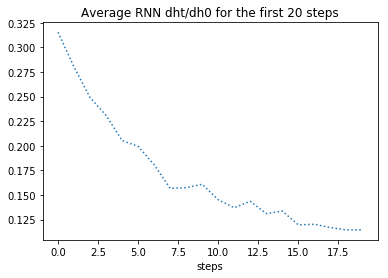

In [12]:
# Mean absolute gradients over steps
steps= [t for t in range(20)]
plt.plot(steps, dhtdh0_agg, linestyle= 'dotted')
plt.title('Average RNN dht/dh0 for the first 20 steps')
plt.xlabel('steps')
plt.savefig('/Users/necromancerchenmy/Desktop/honours_thesis/thesis/thesis_proposal/thesis proposal/rnn_dhtdh0_first20.png')


In [13]:
ds = tf.data.Dataset.from_tensor_slices((xtr_pad, ytr)).batch(100)

@tf.function
# Compute gradients
def compute_dht_dh0(t, x, h0):
    return tf.gradients(model_rnn(x)[:,t,:], h0)
        
n_b = int(xtr_pad.shape[0]/ 100)  # 400 batches
n_steps = 20   # look up only the first and last 20 steps

dhtdh0_last20= tf.zeros([n_b, n_steps])
for b, (x_batch_train, y_batch_train) in enumerate(ds):  # batches 0,1
    grad_batch= []   # a list of 1403 scalar gradients on the current batch
    for t in range(input_length- n_steps, input_length):  
        # steps 0,...,19
        dhtdh0_b_t = compute_dht_dh0(t, x_batch_train, h0)  # (batch_size, n_units)
        grad_t = tf.reduce_mean(abs(dhtdh0_b_t[0]), [0,1]) # Scalar dctdc0 at the current batch and step
        print('step', t+1, 'of batch' ,b+1, 'done')
        grad_batch.append(grad_t)
    
    dhtdh0_last20= tf.concat([dhtdh0_last20, [grad_batch]], axis = 0)   

dhtdh0_last20_agg= tf.reduce_mean(dhtdh0_last20, 0)  # take rowmean to obtain a vector of shape (20,)
print(dhtdh0_last20_agg.shape)

step 1384 of batch 1 done
step 1385 of batch 1 done
step 1386 of batch 1 done
step 1387 of batch 1 done
step 1388 of batch 1 done
step 1389 of batch 1 done
step 1390 of batch 1 done
step 1391 of batch 1 done
step 1392 of batch 1 done
step 1393 of batch 1 done
step 1394 of batch 1 done
step 1395 of batch 1 done
step 1396 of batch 1 done
step 1397 of batch 1 done
step 1398 of batch 1 done
step 1399 of batch 1 done
step 1400 of batch 1 done
step 1401 of batch 1 done
step 1402 of batch 1 done
step 1403 of batch 1 done
step 1384 of batch 2 done
step 1385 of batch 2 done
step 1386 of batch 2 done
step 1387 of batch 2 done
step 1388 of batch 2 done
step 1389 of batch 2 done
step 1390 of batch 2 done
step 1391 of batch 2 done
step 1392 of batch 2 done
step 1393 of batch 2 done
step 1394 of batch 2 done
step 1395 of batch 2 done
step 1396 of batch 2 done
step 1397 of batch 2 done
step 1398 of batch 2 done
step 1399 of batch 2 done
step 1400 of batch 2 done
step 1401 of batch 2 done
step 1402 of

step 1403 of batch 13 done
step 1384 of batch 14 done
step 1385 of batch 14 done
step 1386 of batch 14 done
step 1387 of batch 14 done
step 1388 of batch 14 done
step 1389 of batch 14 done
step 1390 of batch 14 done
step 1391 of batch 14 done
step 1392 of batch 14 done
step 1393 of batch 14 done
step 1394 of batch 14 done
step 1395 of batch 14 done
step 1396 of batch 14 done
step 1397 of batch 14 done
step 1398 of batch 14 done
step 1399 of batch 14 done
step 1400 of batch 14 done
step 1401 of batch 14 done
step 1402 of batch 14 done
step 1403 of batch 14 done
step 1384 of batch 15 done
step 1385 of batch 15 done
step 1386 of batch 15 done
step 1387 of batch 15 done
step 1388 of batch 15 done
step 1389 of batch 15 done
step 1390 of batch 15 done
step 1391 of batch 15 done
step 1392 of batch 15 done
step 1393 of batch 15 done
step 1394 of batch 15 done
step 1395 of batch 15 done
step 1396 of batch 15 done
step 1397 of batch 15 done
step 1398 of batch 15 done
step 1399 of batch 15 done
s

step 1387 of batch 29 done
step 1388 of batch 29 done
step 1389 of batch 29 done
step 1390 of batch 29 done
step 1391 of batch 29 done
step 1392 of batch 29 done
step 1393 of batch 29 done
step 1394 of batch 29 done
step 1395 of batch 29 done
step 1396 of batch 29 done
step 1397 of batch 29 done
step 1398 of batch 29 done
step 1399 of batch 29 done
step 1400 of batch 29 done
step 1401 of batch 29 done
step 1402 of batch 29 done
step 1403 of batch 29 done
step 1384 of batch 30 done
step 1385 of batch 30 done
step 1386 of batch 30 done
step 1387 of batch 30 done
step 1388 of batch 30 done
step 1389 of batch 30 done
step 1390 of batch 30 done
step 1391 of batch 30 done
step 1392 of batch 30 done
step 1393 of batch 30 done
step 1394 of batch 30 done
step 1395 of batch 30 done
step 1396 of batch 30 done
step 1397 of batch 30 done
step 1398 of batch 30 done
step 1399 of batch 30 done
step 1400 of batch 30 done
step 1401 of batch 30 done
step 1402 of batch 30 done
step 1403 of batch 30 done
s

step 1391 of batch 44 done
step 1392 of batch 44 done
step 1393 of batch 44 done
step 1394 of batch 44 done
step 1395 of batch 44 done
step 1396 of batch 44 done
step 1397 of batch 44 done
step 1398 of batch 44 done
step 1399 of batch 44 done
step 1400 of batch 44 done
step 1401 of batch 44 done
step 1402 of batch 44 done
step 1403 of batch 44 done
step 1384 of batch 45 done
step 1385 of batch 45 done
step 1386 of batch 45 done
step 1387 of batch 45 done
step 1388 of batch 45 done
step 1389 of batch 45 done
step 1390 of batch 45 done
step 1391 of batch 45 done
step 1392 of batch 45 done
step 1393 of batch 45 done
step 1394 of batch 45 done
step 1395 of batch 45 done
step 1396 of batch 45 done
step 1397 of batch 45 done
step 1398 of batch 45 done
step 1399 of batch 45 done
step 1400 of batch 45 done
step 1401 of batch 45 done
step 1402 of batch 45 done
step 1403 of batch 45 done
step 1384 of batch 46 done
step 1385 of batch 46 done
step 1386 of batch 46 done
step 1387 of batch 46 done
s

step 1395 of batch 59 done
step 1396 of batch 59 done
step 1397 of batch 59 done
step 1398 of batch 59 done
step 1399 of batch 59 done
step 1400 of batch 59 done
step 1401 of batch 59 done
step 1402 of batch 59 done
step 1403 of batch 59 done
step 1384 of batch 60 done
step 1385 of batch 60 done
step 1386 of batch 60 done
step 1387 of batch 60 done
step 1388 of batch 60 done
step 1389 of batch 60 done
step 1390 of batch 60 done
step 1391 of batch 60 done
step 1392 of batch 60 done
step 1393 of batch 60 done
step 1394 of batch 60 done
step 1395 of batch 60 done
step 1396 of batch 60 done
step 1397 of batch 60 done
step 1398 of batch 60 done
step 1399 of batch 60 done
step 1400 of batch 60 done
step 1401 of batch 60 done
step 1402 of batch 60 done
step 1403 of batch 60 done
step 1384 of batch 61 done
step 1385 of batch 61 done
step 1386 of batch 61 done
step 1387 of batch 61 done
step 1388 of batch 61 done
step 1389 of batch 61 done
step 1390 of batch 61 done
step 1391 of batch 61 done
s

step 1399 of batch 74 done
step 1400 of batch 74 done
step 1401 of batch 74 done
step 1402 of batch 74 done
step 1403 of batch 74 done
step 1384 of batch 75 done
step 1385 of batch 75 done
step 1386 of batch 75 done
step 1387 of batch 75 done
step 1388 of batch 75 done
step 1389 of batch 75 done
step 1390 of batch 75 done
step 1391 of batch 75 done
step 1392 of batch 75 done
step 1393 of batch 75 done
step 1394 of batch 75 done
step 1395 of batch 75 done
step 1396 of batch 75 done
step 1397 of batch 75 done
step 1398 of batch 75 done
step 1399 of batch 75 done
step 1400 of batch 75 done
step 1401 of batch 75 done
step 1402 of batch 75 done
step 1403 of batch 75 done
step 1384 of batch 76 done
step 1385 of batch 76 done
step 1386 of batch 76 done
step 1387 of batch 76 done
step 1388 of batch 76 done
step 1389 of batch 76 done
step 1390 of batch 76 done
step 1391 of batch 76 done
step 1392 of batch 76 done
step 1393 of batch 76 done
step 1394 of batch 76 done
step 1395 of batch 76 done
s

step 1403 of batch 89 done
step 1384 of batch 90 done
step 1385 of batch 90 done
step 1386 of batch 90 done
step 1387 of batch 90 done
step 1388 of batch 90 done
step 1389 of batch 90 done
step 1390 of batch 90 done
step 1391 of batch 90 done
step 1392 of batch 90 done
step 1393 of batch 90 done
step 1394 of batch 90 done
step 1395 of batch 90 done
step 1396 of batch 90 done
step 1397 of batch 90 done
step 1398 of batch 90 done
step 1399 of batch 90 done
step 1400 of batch 90 done
step 1401 of batch 90 done
step 1402 of batch 90 done
step 1403 of batch 90 done
step 1384 of batch 91 done
step 1385 of batch 91 done
step 1386 of batch 91 done
step 1387 of batch 91 done
step 1388 of batch 91 done
step 1389 of batch 91 done
step 1390 of batch 91 done
step 1391 of batch 91 done
step 1392 of batch 91 done
step 1393 of batch 91 done
step 1394 of batch 91 done
step 1395 of batch 91 done
step 1396 of batch 91 done
step 1397 of batch 91 done
step 1398 of batch 91 done
step 1399 of batch 91 done
s

step 1403 of batch 104 done
step 1384 of batch 105 done
step 1385 of batch 105 done
step 1386 of batch 105 done
step 1387 of batch 105 done
step 1388 of batch 105 done
step 1389 of batch 105 done
step 1390 of batch 105 done
step 1391 of batch 105 done
step 1392 of batch 105 done
step 1393 of batch 105 done
step 1394 of batch 105 done
step 1395 of batch 105 done
step 1396 of batch 105 done
step 1397 of batch 105 done
step 1398 of batch 105 done
step 1399 of batch 105 done
step 1400 of batch 105 done
step 1401 of batch 105 done
step 1402 of batch 105 done
step 1403 of batch 105 done
step 1384 of batch 106 done
step 1385 of batch 106 done
step 1386 of batch 106 done
step 1387 of batch 106 done
step 1388 of batch 106 done
step 1389 of batch 106 done
step 1390 of batch 106 done
step 1391 of batch 106 done
step 1392 of batch 106 done
step 1393 of batch 106 done
step 1394 of batch 106 done
step 1395 of batch 106 done
step 1396 of batch 106 done
step 1397 of batch 106 done
step 1398 of batch 1

step 1396 of batch 119 done
step 1397 of batch 119 done
step 1398 of batch 119 done
step 1399 of batch 119 done
step 1400 of batch 119 done
step 1401 of batch 119 done
step 1402 of batch 119 done
step 1403 of batch 119 done
step 1384 of batch 120 done
step 1385 of batch 120 done
step 1386 of batch 120 done
step 1387 of batch 120 done
step 1388 of batch 120 done
step 1389 of batch 120 done
step 1390 of batch 120 done
step 1391 of batch 120 done
step 1392 of batch 120 done
step 1393 of batch 120 done
step 1394 of batch 120 done
step 1395 of batch 120 done
step 1396 of batch 120 done
step 1397 of batch 120 done
step 1398 of batch 120 done
step 1399 of batch 120 done
step 1400 of batch 120 done
step 1401 of batch 120 done
step 1402 of batch 120 done
step 1403 of batch 120 done
step 1384 of batch 121 done
step 1385 of batch 121 done
step 1386 of batch 121 done
step 1387 of batch 121 done
step 1388 of batch 121 done
step 1389 of batch 121 done
step 1390 of batch 121 done
step 1391 of batch 1

step 1389 of batch 134 done
step 1390 of batch 134 done
step 1391 of batch 134 done
step 1392 of batch 134 done
step 1393 of batch 134 done
step 1394 of batch 134 done
step 1395 of batch 134 done
step 1396 of batch 134 done
step 1397 of batch 134 done
step 1398 of batch 134 done
step 1399 of batch 134 done
step 1400 of batch 134 done
step 1401 of batch 134 done
step 1402 of batch 134 done
step 1403 of batch 134 done
step 1384 of batch 135 done
step 1385 of batch 135 done
step 1386 of batch 135 done
step 1387 of batch 135 done
step 1388 of batch 135 done
step 1389 of batch 135 done
step 1390 of batch 135 done
step 1391 of batch 135 done
step 1392 of batch 135 done
step 1393 of batch 135 done
step 1394 of batch 135 done
step 1395 of batch 135 done
step 1396 of batch 135 done
step 1397 of batch 135 done
step 1398 of batch 135 done
step 1399 of batch 135 done
step 1400 of batch 135 done
step 1401 of batch 135 done
step 1402 of batch 135 done
step 1403 of batch 135 done
step 1384 of batch 1

step 1402 of batch 148 done
step 1403 of batch 148 done
step 1384 of batch 149 done
step 1385 of batch 149 done
step 1386 of batch 149 done
step 1387 of batch 149 done
step 1388 of batch 149 done
step 1389 of batch 149 done
step 1390 of batch 149 done
step 1391 of batch 149 done
step 1392 of batch 149 done
step 1393 of batch 149 done
step 1394 of batch 149 done
step 1395 of batch 149 done
step 1396 of batch 149 done
step 1397 of batch 149 done
step 1398 of batch 149 done
step 1399 of batch 149 done
step 1400 of batch 149 done
step 1401 of batch 149 done
step 1402 of batch 149 done
step 1403 of batch 149 done
step 1384 of batch 150 done
step 1385 of batch 150 done
step 1386 of batch 150 done
step 1387 of batch 150 done
step 1388 of batch 150 done
step 1389 of batch 150 done
step 1390 of batch 150 done
step 1391 of batch 150 done
step 1392 of batch 150 done
step 1393 of batch 150 done
step 1394 of batch 150 done
step 1395 of batch 150 done
step 1396 of batch 150 done
step 1397 of batch 1

step 1395 of batch 163 done
step 1396 of batch 163 done
step 1397 of batch 163 done
step 1398 of batch 163 done
step 1399 of batch 163 done
step 1400 of batch 163 done
step 1401 of batch 163 done
step 1402 of batch 163 done
step 1403 of batch 163 done
step 1384 of batch 164 done
step 1385 of batch 164 done
step 1386 of batch 164 done
step 1387 of batch 164 done
step 1388 of batch 164 done
step 1389 of batch 164 done
step 1390 of batch 164 done
step 1391 of batch 164 done
step 1392 of batch 164 done
step 1393 of batch 164 done
step 1394 of batch 164 done
step 1395 of batch 164 done
step 1396 of batch 164 done
step 1397 of batch 164 done
step 1398 of batch 164 done
step 1399 of batch 164 done
step 1400 of batch 164 done
step 1401 of batch 164 done
step 1402 of batch 164 done
step 1403 of batch 164 done
step 1384 of batch 165 done
step 1385 of batch 165 done
step 1386 of batch 165 done
step 1387 of batch 165 done
step 1388 of batch 165 done
step 1389 of batch 165 done
step 1390 of batch 1

step 1388 of batch 178 done
step 1389 of batch 178 done
step 1390 of batch 178 done
step 1391 of batch 178 done
step 1392 of batch 178 done
step 1393 of batch 178 done
step 1394 of batch 178 done
step 1395 of batch 178 done
step 1396 of batch 178 done
step 1397 of batch 178 done
step 1398 of batch 178 done
step 1399 of batch 178 done
step 1400 of batch 178 done
step 1401 of batch 178 done
step 1402 of batch 178 done
step 1403 of batch 178 done
step 1384 of batch 179 done
step 1385 of batch 179 done
step 1386 of batch 179 done
step 1387 of batch 179 done
step 1388 of batch 179 done
step 1389 of batch 179 done
step 1390 of batch 179 done
step 1391 of batch 179 done
step 1392 of batch 179 done
step 1393 of batch 179 done
step 1394 of batch 179 done
step 1395 of batch 179 done
step 1396 of batch 179 done
step 1397 of batch 179 done
step 1398 of batch 179 done
step 1399 of batch 179 done
step 1400 of batch 179 done
step 1401 of batch 179 done
step 1402 of batch 179 done
step 1403 of batch 1

step 1401 of batch 192 done
step 1402 of batch 192 done
step 1403 of batch 192 done
step 1384 of batch 193 done
step 1385 of batch 193 done
step 1386 of batch 193 done
step 1387 of batch 193 done
step 1388 of batch 193 done
step 1389 of batch 193 done
step 1390 of batch 193 done
step 1391 of batch 193 done
step 1392 of batch 193 done
step 1393 of batch 193 done
step 1394 of batch 193 done
step 1395 of batch 193 done
step 1396 of batch 193 done
step 1397 of batch 193 done
step 1398 of batch 193 done
step 1399 of batch 193 done
step 1400 of batch 193 done
step 1401 of batch 193 done
step 1402 of batch 193 done
step 1403 of batch 193 done
step 1384 of batch 194 done
step 1385 of batch 194 done
step 1386 of batch 194 done
step 1387 of batch 194 done
step 1388 of batch 194 done
step 1389 of batch 194 done
step 1390 of batch 194 done
step 1391 of batch 194 done
step 1392 of batch 194 done
step 1393 of batch 194 done
step 1394 of batch 194 done
step 1395 of batch 194 done
step 1396 of batch 1

step 1394 of batch 207 done
step 1395 of batch 207 done
step 1396 of batch 207 done
step 1397 of batch 207 done
step 1398 of batch 207 done
step 1399 of batch 207 done
step 1400 of batch 207 done
step 1401 of batch 207 done
step 1402 of batch 207 done
step 1403 of batch 207 done
step 1384 of batch 208 done
step 1385 of batch 208 done
step 1386 of batch 208 done
step 1387 of batch 208 done
step 1388 of batch 208 done
step 1389 of batch 208 done
step 1390 of batch 208 done
step 1391 of batch 208 done
step 1392 of batch 208 done
step 1393 of batch 208 done
step 1394 of batch 208 done
step 1395 of batch 208 done
step 1396 of batch 208 done
step 1397 of batch 208 done
step 1398 of batch 208 done
step 1399 of batch 208 done
step 1400 of batch 208 done
step 1401 of batch 208 done
step 1402 of batch 208 done
step 1403 of batch 208 done
step 1384 of batch 209 done
step 1385 of batch 209 done
step 1386 of batch 209 done
step 1387 of batch 209 done
step 1388 of batch 209 done
step 1389 of batch 2

step 1387 of batch 222 done
step 1388 of batch 222 done
step 1389 of batch 222 done
step 1390 of batch 222 done
step 1391 of batch 222 done
step 1392 of batch 222 done
step 1393 of batch 222 done
step 1394 of batch 222 done
step 1395 of batch 222 done
step 1396 of batch 222 done
step 1397 of batch 222 done
step 1398 of batch 222 done
step 1399 of batch 222 done
step 1400 of batch 222 done
step 1401 of batch 222 done
step 1402 of batch 222 done
step 1403 of batch 222 done
step 1384 of batch 223 done
step 1385 of batch 223 done
step 1386 of batch 223 done
step 1387 of batch 223 done
step 1388 of batch 223 done
step 1389 of batch 223 done
step 1390 of batch 223 done
step 1391 of batch 223 done
step 1392 of batch 223 done
step 1393 of batch 223 done
step 1394 of batch 223 done
step 1395 of batch 223 done
step 1396 of batch 223 done
step 1397 of batch 223 done
step 1398 of batch 223 done
step 1399 of batch 223 done
step 1400 of batch 223 done
step 1401 of batch 223 done
step 1402 of batch 2

step 1400 of batch 236 done
step 1401 of batch 236 done
step 1402 of batch 236 done
step 1403 of batch 236 done
step 1384 of batch 237 done
step 1385 of batch 237 done
step 1386 of batch 237 done
step 1387 of batch 237 done
step 1388 of batch 237 done
step 1389 of batch 237 done
step 1390 of batch 237 done
step 1391 of batch 237 done
step 1392 of batch 237 done
step 1393 of batch 237 done
step 1394 of batch 237 done
step 1395 of batch 237 done
step 1396 of batch 237 done
step 1397 of batch 237 done
step 1398 of batch 237 done
step 1399 of batch 237 done
step 1400 of batch 237 done
step 1401 of batch 237 done
step 1402 of batch 237 done
step 1403 of batch 237 done
step 1384 of batch 238 done
step 1385 of batch 238 done
step 1386 of batch 238 done
step 1387 of batch 238 done
step 1388 of batch 238 done
step 1389 of batch 238 done
step 1390 of batch 238 done
step 1391 of batch 238 done
step 1392 of batch 238 done
step 1393 of batch 238 done
step 1394 of batch 238 done
step 1395 of batch 2

step 1393 of batch 251 done
step 1394 of batch 251 done
step 1395 of batch 251 done
step 1396 of batch 251 done
step 1397 of batch 251 done
step 1398 of batch 251 done
step 1399 of batch 251 done
step 1400 of batch 251 done
step 1401 of batch 251 done
step 1402 of batch 251 done
step 1403 of batch 251 done
step 1384 of batch 252 done
step 1385 of batch 252 done
step 1386 of batch 252 done
step 1387 of batch 252 done
step 1388 of batch 252 done
step 1389 of batch 252 done
step 1390 of batch 252 done
step 1391 of batch 252 done
step 1392 of batch 252 done
step 1393 of batch 252 done
step 1394 of batch 252 done
step 1395 of batch 252 done
step 1396 of batch 252 done
step 1397 of batch 252 done
step 1398 of batch 252 done
step 1399 of batch 252 done
step 1400 of batch 252 done
step 1401 of batch 252 done
step 1402 of batch 252 done
step 1403 of batch 252 done
step 1384 of batch 253 done
step 1385 of batch 253 done
step 1386 of batch 253 done
step 1387 of batch 253 done
step 1388 of batch 2

step 1386 of batch 266 done
step 1387 of batch 266 done
step 1388 of batch 266 done
step 1389 of batch 266 done
step 1390 of batch 266 done
step 1391 of batch 266 done
step 1392 of batch 266 done
step 1393 of batch 266 done
step 1394 of batch 266 done
step 1395 of batch 266 done
step 1396 of batch 266 done
step 1397 of batch 266 done
step 1398 of batch 266 done
step 1399 of batch 266 done
step 1400 of batch 266 done
step 1401 of batch 266 done
step 1402 of batch 266 done
step 1403 of batch 266 done
step 1384 of batch 267 done
step 1385 of batch 267 done
step 1386 of batch 267 done
step 1387 of batch 267 done
step 1388 of batch 267 done
step 1389 of batch 267 done
step 1390 of batch 267 done
step 1391 of batch 267 done
step 1392 of batch 267 done
step 1393 of batch 267 done
step 1394 of batch 267 done
step 1395 of batch 267 done
step 1396 of batch 267 done
step 1397 of batch 267 done
step 1398 of batch 267 done
step 1399 of batch 267 done
step 1400 of batch 267 done
step 1401 of batch 2

step 1399 of batch 280 done
step 1400 of batch 280 done
step 1401 of batch 280 done
step 1402 of batch 280 done
step 1403 of batch 280 done
step 1384 of batch 281 done
step 1385 of batch 281 done
step 1386 of batch 281 done
step 1387 of batch 281 done
step 1388 of batch 281 done
step 1389 of batch 281 done
step 1390 of batch 281 done
step 1391 of batch 281 done
step 1392 of batch 281 done
step 1393 of batch 281 done
step 1394 of batch 281 done
step 1395 of batch 281 done
step 1396 of batch 281 done
step 1397 of batch 281 done
step 1398 of batch 281 done
step 1399 of batch 281 done
step 1400 of batch 281 done
step 1401 of batch 281 done
step 1402 of batch 281 done
step 1403 of batch 281 done
step 1384 of batch 282 done
step 1385 of batch 282 done
step 1386 of batch 282 done
step 1387 of batch 282 done
step 1388 of batch 282 done
step 1389 of batch 282 done
step 1390 of batch 282 done
step 1391 of batch 282 done
step 1392 of batch 282 done
step 1393 of batch 282 done
step 1394 of batch 2

step 1392 of batch 295 done
step 1393 of batch 295 done
step 1394 of batch 295 done
step 1395 of batch 295 done
step 1396 of batch 295 done
step 1397 of batch 295 done
step 1398 of batch 295 done
step 1399 of batch 295 done
step 1400 of batch 295 done
step 1401 of batch 295 done
step 1402 of batch 295 done
step 1403 of batch 295 done
step 1384 of batch 296 done
step 1385 of batch 296 done
step 1386 of batch 296 done
step 1387 of batch 296 done
step 1388 of batch 296 done
step 1389 of batch 296 done
step 1390 of batch 296 done
step 1391 of batch 296 done
step 1392 of batch 296 done
step 1393 of batch 296 done
step 1394 of batch 296 done
step 1395 of batch 296 done
step 1396 of batch 296 done
step 1397 of batch 296 done
step 1398 of batch 296 done
step 1399 of batch 296 done
step 1400 of batch 296 done
step 1401 of batch 296 done
step 1402 of batch 296 done
step 1403 of batch 296 done
step 1384 of batch 297 done
step 1385 of batch 297 done
step 1386 of batch 297 done
step 1387 of batch 2

step 1385 of batch 310 done
step 1386 of batch 310 done
step 1387 of batch 310 done
step 1388 of batch 310 done
step 1389 of batch 310 done
step 1390 of batch 310 done
step 1391 of batch 310 done
step 1392 of batch 310 done
step 1393 of batch 310 done
step 1394 of batch 310 done
step 1395 of batch 310 done
step 1396 of batch 310 done
step 1397 of batch 310 done
step 1398 of batch 310 done
step 1399 of batch 310 done
step 1400 of batch 310 done
step 1401 of batch 310 done
step 1402 of batch 310 done
step 1403 of batch 310 done
step 1384 of batch 311 done
step 1385 of batch 311 done
step 1386 of batch 311 done
step 1387 of batch 311 done
step 1388 of batch 311 done
step 1389 of batch 311 done
step 1390 of batch 311 done
step 1391 of batch 311 done
step 1392 of batch 311 done
step 1393 of batch 311 done
step 1394 of batch 311 done
step 1395 of batch 311 done
step 1396 of batch 311 done
step 1397 of batch 311 done
step 1398 of batch 311 done
step 1399 of batch 311 done
step 1400 of batch 3

step 1398 of batch 324 done
step 1399 of batch 324 done
step 1400 of batch 324 done
step 1401 of batch 324 done
step 1402 of batch 324 done
step 1403 of batch 324 done
step 1384 of batch 325 done
step 1385 of batch 325 done
step 1386 of batch 325 done
step 1387 of batch 325 done
step 1388 of batch 325 done
step 1389 of batch 325 done
step 1390 of batch 325 done
step 1391 of batch 325 done
step 1392 of batch 325 done
step 1393 of batch 325 done
step 1394 of batch 325 done
step 1395 of batch 325 done
step 1396 of batch 325 done
step 1397 of batch 325 done
step 1398 of batch 325 done
step 1399 of batch 325 done
step 1400 of batch 325 done
step 1401 of batch 325 done
step 1402 of batch 325 done
step 1403 of batch 325 done
step 1384 of batch 326 done
step 1385 of batch 326 done
step 1386 of batch 326 done
step 1387 of batch 326 done
step 1388 of batch 326 done
step 1389 of batch 326 done
step 1390 of batch 326 done
step 1391 of batch 326 done
step 1392 of batch 326 done
step 1393 of batch 3

step 1391 of batch 339 done
step 1392 of batch 339 done
step 1393 of batch 339 done
step 1394 of batch 339 done
step 1395 of batch 339 done
step 1396 of batch 339 done
step 1397 of batch 339 done
step 1398 of batch 339 done
step 1399 of batch 339 done
step 1400 of batch 339 done
step 1401 of batch 339 done
step 1402 of batch 339 done
step 1403 of batch 339 done
step 1384 of batch 340 done
step 1385 of batch 340 done
step 1386 of batch 340 done
step 1387 of batch 340 done
step 1388 of batch 340 done
step 1389 of batch 340 done
step 1390 of batch 340 done
step 1391 of batch 340 done
step 1392 of batch 340 done
step 1393 of batch 340 done
step 1394 of batch 340 done
step 1395 of batch 340 done
step 1396 of batch 340 done
step 1397 of batch 340 done
step 1398 of batch 340 done
step 1399 of batch 340 done
step 1400 of batch 340 done
step 1401 of batch 340 done
step 1402 of batch 340 done
step 1403 of batch 340 done
step 1384 of batch 341 done
step 1385 of batch 341 done
step 1386 of batch 3

step 1384 of batch 354 done
step 1385 of batch 354 done
step 1386 of batch 354 done
step 1387 of batch 354 done
step 1388 of batch 354 done
step 1389 of batch 354 done
step 1390 of batch 354 done
step 1391 of batch 354 done
step 1392 of batch 354 done
step 1393 of batch 354 done
step 1394 of batch 354 done
step 1395 of batch 354 done
step 1396 of batch 354 done
step 1397 of batch 354 done
step 1398 of batch 354 done
step 1399 of batch 354 done
step 1400 of batch 354 done
step 1401 of batch 354 done
step 1402 of batch 354 done
step 1403 of batch 354 done
step 1384 of batch 355 done
step 1385 of batch 355 done
step 1386 of batch 355 done
step 1387 of batch 355 done
step 1388 of batch 355 done
step 1389 of batch 355 done
step 1390 of batch 355 done
step 1391 of batch 355 done
step 1392 of batch 355 done
step 1393 of batch 355 done
step 1394 of batch 355 done
step 1395 of batch 355 done
step 1396 of batch 355 done
step 1397 of batch 355 done
step 1398 of batch 355 done
step 1399 of batch 3

step 1397 of batch 368 done
step 1398 of batch 368 done
step 1399 of batch 368 done
step 1400 of batch 368 done
step 1401 of batch 368 done
step 1402 of batch 368 done
step 1403 of batch 368 done
step 1384 of batch 369 done
step 1385 of batch 369 done
step 1386 of batch 369 done
step 1387 of batch 369 done
step 1388 of batch 369 done
step 1389 of batch 369 done
step 1390 of batch 369 done
step 1391 of batch 369 done
step 1392 of batch 369 done
step 1393 of batch 369 done
step 1394 of batch 369 done
step 1395 of batch 369 done
step 1396 of batch 369 done
step 1397 of batch 369 done
step 1398 of batch 369 done
step 1399 of batch 369 done
step 1400 of batch 369 done
step 1401 of batch 369 done
step 1402 of batch 369 done
step 1403 of batch 369 done
step 1384 of batch 370 done
step 1385 of batch 370 done
step 1386 of batch 370 done
step 1387 of batch 370 done
step 1388 of batch 370 done
step 1389 of batch 370 done
step 1390 of batch 370 done
step 1391 of batch 370 done
step 1392 of batch 3

step 1390 of batch 383 done
step 1391 of batch 383 done
step 1392 of batch 383 done
step 1393 of batch 383 done
step 1394 of batch 383 done
step 1395 of batch 383 done
step 1396 of batch 383 done
step 1397 of batch 383 done
step 1398 of batch 383 done
step 1399 of batch 383 done
step 1400 of batch 383 done
step 1401 of batch 383 done
step 1402 of batch 383 done
step 1403 of batch 383 done
step 1384 of batch 384 done
step 1385 of batch 384 done
step 1386 of batch 384 done
step 1387 of batch 384 done
step 1388 of batch 384 done
step 1389 of batch 384 done
step 1390 of batch 384 done
step 1391 of batch 384 done
step 1392 of batch 384 done
step 1393 of batch 384 done
step 1394 of batch 384 done
step 1395 of batch 384 done
step 1396 of batch 384 done
step 1397 of batch 384 done
step 1398 of batch 384 done
step 1399 of batch 384 done
step 1400 of batch 384 done
step 1401 of batch 384 done
step 1402 of batch 384 done
step 1403 of batch 384 done
step 1384 of batch 385 done
step 1385 of batch 3

step 1403 of batch 397 done
step 1384 of batch 398 done
step 1385 of batch 398 done
step 1386 of batch 398 done
step 1387 of batch 398 done
step 1388 of batch 398 done
step 1389 of batch 398 done
step 1390 of batch 398 done
step 1391 of batch 398 done
step 1392 of batch 398 done
step 1393 of batch 398 done
step 1394 of batch 398 done
step 1395 of batch 398 done
step 1396 of batch 398 done
step 1397 of batch 398 done
step 1398 of batch 398 done
step 1399 of batch 398 done
step 1400 of batch 398 done
step 1401 of batch 398 done
step 1402 of batch 398 done
step 1403 of batch 398 done
step 1384 of batch 399 done
step 1385 of batch 399 done
step 1386 of batch 399 done
step 1387 of batch 399 done
step 1388 of batch 399 done
step 1389 of batch 399 done
step 1390 of batch 399 done
step 1391 of batch 399 done
step 1392 of batch 399 done
step 1393 of batch 399 done
step 1394 of batch 399 done
step 1395 of batch 399 done
step 1396 of batch 399 done
step 1397 of batch 399 done
step 1398 of batch 3

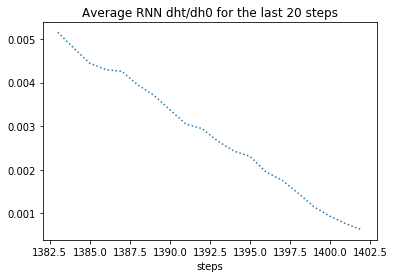

In [14]:
# Mean absolute gradients over steps
steps= [t for t in range(input_length- 20, input_length)]
plt.plot(steps, dhtdh0_last20_agg, linestyle= 'dotted')
plt.title('Average RNN dht/dh0 for the last 20 steps')
plt.xlabel('steps')
plt.savefig('/Users/necromancerchenmy/Desktop/honours_thesis/thesis/thesis_proposal/thesis proposal/rnn_dhtdh0_last20.png')


-----------

In [15]:
# Define LSTM model
batch_size = 100
inp= Input(batch_shape= (batch_size, input_length), name= 'input') 
emb_out= Embedding(input_dim, output_dim, input_length= input_length, 
                         weights= [Emat], trainable= False, name= 'embedding')(inp)

# Custom LSTM cell:
class LSTMCellwithStates(LSTMCell):
    def call(self, inputs, states, training=None):
        real_inputs = inputs[:,:self.units] # decouple [h, c]
        outputs, [h,c] = super().call(real_inputs, states, training=training)
        return tf.concat([h, c], axis=1), [h,c]
    
rnn = RNN(LSTMCellwithStates(200), return_sequences= True, return_state= False, name= 'LSTM') 

# Initial hidden states
h0 = tf.Variable(tf.random.uniform((batch_size, 200)))
c0 = tf.Variable(tf.random.uniform((batch_size, 200)))
rnn_allstates= rnn(emb_out, initial_state= [h0, c0]) 
print(rnn_allstates.shape) 

# Construct a model that only outputs c1, ..., cT:
model_lstm_ct = Model(inputs=inp, outputs= rnn_allstates[:, :, 200:], name= 'model_lstm')
model_lstm_ct.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model_lstm_ct.layers


(100, 1403, 400)


In [16]:
ds = tf.data.Dataset.from_tensor_slices((xtr_pad, ytr)).batch(100)

@tf.function
# Compute gradients
def compute_dct_dc0(t, x, c0):
    return tf.gradients(model_lstm_ct(x)[:,t,:], c0)
        
n_b = int(xtr_pad.shape[0]/ 100)  # 400 batches
n_steps = 20   # look up only the first and last 20 steps

dctdc0_20= tf.zeros([n_b, n_steps])
for b, (x_batch_train, y_batch_train) in enumerate(ds):  # batches 0,1
    grad_batch= []   
    for t in range(n_steps):  
        # steps 0,...,19
        dctdc0_b_t = compute_dct_dc0(t, x_batch_train, c0)  # (batch_size, n_units)
        grad_t = tf.reduce_mean(abs(dctdc0_b_t[0]), [0,1]) # Scalar dctdc0 at the current batch and step
        print('step', t+1, 'of batch' ,b+1, 'done')
        grad_batch.append(grad_t)
    
    dctdc0_20= tf.concat([dctdc0_20, [grad_batch]], axis = 0)   

dctdc0_20_agg= tf.reduce_mean(dctdc0_20, 0)  # take rowmean to obtain a vector of shape (20,)
print(dctdc0_20_agg.shape)


step 1 of batch 1 done
step 2 of batch 1 done
step 3 of batch 1 done
step 4 of batch 1 done
step 5 of batch 1 done
step 6 of batch 1 done
step 7 of batch 1 done
step 8 of batch 1 done
step 9 of batch 1 done
step 10 of batch 1 done
step 11 of batch 1 done
step 12 of batch 1 done
step 13 of batch 1 done
step 14 of batch 1 done
step 15 of batch 1 done
step 16 of batch 1 done
step 17 of batch 1 done
step 18 of batch 1 done
step 19 of batch 1 done
step 20 of batch 1 done
step 1 of batch 2 done
step 2 of batch 2 done
step 3 of batch 2 done
step 4 of batch 2 done
step 5 of batch 2 done
step 6 of batch 2 done
step 7 of batch 2 done
step 8 of batch 2 done
step 9 of batch 2 done
step 10 of batch 2 done
step 11 of batch 2 done
step 12 of batch 2 done
step 13 of batch 2 done
step 14 of batch 2 done
step 15 of batch 2 done
step 16 of batch 2 done
step 17 of batch 2 done
step 18 of batch 2 done
step 19 of batch 2 done
step 20 of batch 2 done
step 1 of batch 3 done
step 2 of batch 3 done
step 3 of ba

step 6 of batch 15 done
step 7 of batch 15 done
step 8 of batch 15 done
step 9 of batch 15 done
step 10 of batch 15 done
step 11 of batch 15 done
step 12 of batch 15 done
step 13 of batch 15 done
step 14 of batch 15 done
step 15 of batch 15 done
step 16 of batch 15 done
step 17 of batch 15 done
step 18 of batch 15 done
step 19 of batch 15 done
step 20 of batch 15 done
step 1 of batch 16 done
step 2 of batch 16 done
step 3 of batch 16 done
step 4 of batch 16 done
step 5 of batch 16 done
step 6 of batch 16 done
step 7 of batch 16 done
step 8 of batch 16 done
step 9 of batch 16 done
step 10 of batch 16 done
step 11 of batch 16 done
step 12 of batch 16 done
step 13 of batch 16 done
step 14 of batch 16 done
step 15 of batch 16 done
step 16 of batch 16 done
step 17 of batch 16 done
step 18 of batch 16 done
step 19 of batch 16 done
step 20 of batch 16 done
step 1 of batch 17 done
step 2 of batch 17 done
step 3 of batch 17 done
step 4 of batch 17 done
step 5 of batch 17 done
step 6 of batch 17

step 20 of batch 31 done
step 1 of batch 32 done
step 2 of batch 32 done
step 3 of batch 32 done
step 4 of batch 32 done
step 5 of batch 32 done
step 6 of batch 32 done
step 7 of batch 32 done
step 8 of batch 32 done
step 9 of batch 32 done
step 10 of batch 32 done
step 11 of batch 32 done
step 12 of batch 32 done
step 13 of batch 32 done
step 14 of batch 32 done
step 15 of batch 32 done
step 16 of batch 32 done
step 17 of batch 32 done
step 18 of batch 32 done
step 19 of batch 32 done
step 20 of batch 32 done
step 1 of batch 33 done
step 2 of batch 33 done
step 3 of batch 33 done
step 4 of batch 33 done
step 5 of batch 33 done
step 6 of batch 33 done
step 7 of batch 33 done
step 8 of batch 33 done
step 9 of batch 33 done
step 10 of batch 33 done
step 11 of batch 33 done
step 12 of batch 33 done
step 13 of batch 33 done
step 14 of batch 33 done
step 15 of batch 33 done
step 16 of batch 33 done
step 17 of batch 33 done
step 18 of batch 33 done
step 19 of batch 33 done
step 20 of batch 3

step 14 of batch 48 done
step 15 of batch 48 done
step 16 of batch 48 done
step 17 of batch 48 done
step 18 of batch 48 done
step 19 of batch 48 done
step 20 of batch 48 done
step 1 of batch 49 done
step 2 of batch 49 done
step 3 of batch 49 done
step 4 of batch 49 done
step 5 of batch 49 done
step 6 of batch 49 done
step 7 of batch 49 done
step 8 of batch 49 done
step 9 of batch 49 done
step 10 of batch 49 done
step 11 of batch 49 done
step 12 of batch 49 done
step 13 of batch 49 done
step 14 of batch 49 done
step 15 of batch 49 done
step 16 of batch 49 done
step 17 of batch 49 done
step 18 of batch 49 done
step 19 of batch 49 done
step 20 of batch 49 done
step 1 of batch 50 done
step 2 of batch 50 done
step 3 of batch 50 done
step 4 of batch 50 done
step 5 of batch 50 done
step 6 of batch 50 done
step 7 of batch 50 done
step 8 of batch 50 done
step 9 of batch 50 done
step 10 of batch 50 done
step 11 of batch 50 done
step 12 of batch 50 done
step 13 of batch 50 done
step 14 of batch 5

step 8 of batch 65 done
step 9 of batch 65 done
step 10 of batch 65 done
step 11 of batch 65 done
step 12 of batch 65 done
step 13 of batch 65 done
step 14 of batch 65 done
step 15 of batch 65 done
step 16 of batch 65 done
step 17 of batch 65 done
step 18 of batch 65 done
step 19 of batch 65 done
step 20 of batch 65 done
step 1 of batch 66 done
step 2 of batch 66 done
step 3 of batch 66 done
step 4 of batch 66 done
step 5 of batch 66 done
step 6 of batch 66 done
step 7 of batch 66 done
step 8 of batch 66 done
step 9 of batch 66 done
step 10 of batch 66 done
step 11 of batch 66 done
step 12 of batch 66 done
step 13 of batch 66 done
step 14 of batch 66 done
step 15 of batch 66 done
step 16 of batch 66 done
step 17 of batch 66 done
step 18 of batch 66 done
step 19 of batch 66 done
step 20 of batch 66 done
step 1 of batch 67 done
step 2 of batch 67 done
step 3 of batch 67 done
step 4 of batch 67 done
step 5 of batch 67 done
step 6 of batch 67 done
step 7 of batch 67 done
step 8 of batch 67

step 2 of batch 82 done
step 3 of batch 82 done
step 4 of batch 82 done
step 5 of batch 82 done
step 6 of batch 82 done
step 7 of batch 82 done
step 8 of batch 82 done
step 9 of batch 82 done
step 10 of batch 82 done
step 11 of batch 82 done
step 12 of batch 82 done
step 13 of batch 82 done
step 14 of batch 82 done
step 15 of batch 82 done
step 16 of batch 82 done
step 17 of batch 82 done
step 18 of batch 82 done
step 19 of batch 82 done
step 20 of batch 82 done
step 1 of batch 83 done
step 2 of batch 83 done
step 3 of batch 83 done
step 4 of batch 83 done
step 5 of batch 83 done
step 6 of batch 83 done
step 7 of batch 83 done
step 8 of batch 83 done
step 9 of batch 83 done
step 10 of batch 83 done
step 11 of batch 83 done
step 12 of batch 83 done
step 13 of batch 83 done
step 14 of batch 83 done
step 15 of batch 83 done
step 16 of batch 83 done
step 17 of batch 83 done
step 18 of batch 83 done
step 19 of batch 83 done
step 20 of batch 83 done
step 1 of batch 84 done
step 2 of batch 84

step 16 of batch 98 done
step 17 of batch 98 done
step 18 of batch 98 done
step 19 of batch 98 done
step 20 of batch 98 done
step 1 of batch 99 done
step 2 of batch 99 done
step 3 of batch 99 done
step 4 of batch 99 done
step 5 of batch 99 done
step 6 of batch 99 done
step 7 of batch 99 done
step 8 of batch 99 done
step 9 of batch 99 done
step 10 of batch 99 done
step 11 of batch 99 done
step 12 of batch 99 done
step 13 of batch 99 done
step 14 of batch 99 done
step 15 of batch 99 done
step 16 of batch 99 done
step 17 of batch 99 done
step 18 of batch 99 done
step 19 of batch 99 done
step 20 of batch 99 done
step 1 of batch 100 done
step 2 of batch 100 done
step 3 of batch 100 done
step 4 of batch 100 done
step 5 of batch 100 done
step 6 of batch 100 done
step 7 of batch 100 done
step 8 of batch 100 done
step 9 of batch 100 done
step 10 of batch 100 done
step 11 of batch 100 done
step 12 of batch 100 done
step 13 of batch 100 done
step 14 of batch 100 done
step 15 of batch 100 done
ste

step 18 of batch 114 done
step 19 of batch 114 done
step 20 of batch 114 done
step 1 of batch 115 done
step 2 of batch 115 done
step 3 of batch 115 done
step 4 of batch 115 done
step 5 of batch 115 done
step 6 of batch 115 done
step 7 of batch 115 done
step 8 of batch 115 done
step 9 of batch 115 done
step 10 of batch 115 done
step 11 of batch 115 done
step 12 of batch 115 done
step 13 of batch 115 done
step 14 of batch 115 done
step 15 of batch 115 done
step 16 of batch 115 done
step 17 of batch 115 done
step 18 of batch 115 done
step 19 of batch 115 done
step 20 of batch 115 done
step 1 of batch 116 done
step 2 of batch 116 done
step 3 of batch 116 done
step 4 of batch 116 done
step 5 of batch 116 done
step 6 of batch 116 done
step 7 of batch 116 done
step 8 of batch 116 done
step 9 of batch 116 done
step 10 of batch 116 done
step 11 of batch 116 done
step 12 of batch 116 done
step 13 of batch 116 done
step 14 of batch 116 done
step 15 of batch 116 done
step 16 of batch 116 done
step

step 19 of batch 130 done
step 20 of batch 130 done
step 1 of batch 131 done
step 2 of batch 131 done
step 3 of batch 131 done
step 4 of batch 131 done
step 5 of batch 131 done
step 6 of batch 131 done
step 7 of batch 131 done
step 8 of batch 131 done
step 9 of batch 131 done
step 10 of batch 131 done
step 11 of batch 131 done
step 12 of batch 131 done
step 13 of batch 131 done
step 14 of batch 131 done
step 15 of batch 131 done
step 16 of batch 131 done
step 17 of batch 131 done
step 18 of batch 131 done
step 19 of batch 131 done
step 20 of batch 131 done
step 1 of batch 132 done
step 2 of batch 132 done
step 3 of batch 132 done
step 4 of batch 132 done
step 5 of batch 132 done
step 6 of batch 132 done
step 7 of batch 132 done
step 8 of batch 132 done
step 9 of batch 132 done
step 10 of batch 132 done
step 11 of batch 132 done
step 12 of batch 132 done
step 13 of batch 132 done
step 14 of batch 132 done
step 15 of batch 132 done
step 16 of batch 132 done
step 17 of batch 132 done
step

step 20 of batch 146 done
step 1 of batch 147 done
step 2 of batch 147 done
step 3 of batch 147 done
step 4 of batch 147 done
step 5 of batch 147 done
step 6 of batch 147 done
step 7 of batch 147 done
step 8 of batch 147 done
step 9 of batch 147 done
step 10 of batch 147 done
step 11 of batch 147 done
step 12 of batch 147 done
step 13 of batch 147 done
step 14 of batch 147 done
step 15 of batch 147 done
step 16 of batch 147 done
step 17 of batch 147 done
step 18 of batch 147 done
step 19 of batch 147 done
step 20 of batch 147 done
step 1 of batch 148 done
step 2 of batch 148 done
step 3 of batch 148 done
step 4 of batch 148 done
step 5 of batch 148 done
step 6 of batch 148 done
step 7 of batch 148 done
step 8 of batch 148 done
step 9 of batch 148 done
step 10 of batch 148 done
step 11 of batch 148 done
step 12 of batch 148 done
step 13 of batch 148 done
step 14 of batch 148 done
step 15 of batch 148 done
step 16 of batch 148 done
step 17 of batch 148 done
step 18 of batch 148 done
step

step 1 of batch 163 done
step 2 of batch 163 done
step 3 of batch 163 done
step 4 of batch 163 done
step 5 of batch 163 done
step 6 of batch 163 done
step 7 of batch 163 done
step 8 of batch 163 done
step 9 of batch 163 done
step 10 of batch 163 done
step 11 of batch 163 done
step 12 of batch 163 done
step 13 of batch 163 done
step 14 of batch 163 done
step 15 of batch 163 done
step 16 of batch 163 done
step 17 of batch 163 done
step 18 of batch 163 done
step 19 of batch 163 done
step 20 of batch 163 done
step 1 of batch 164 done
step 2 of batch 164 done
step 3 of batch 164 done
step 4 of batch 164 done
step 5 of batch 164 done
step 6 of batch 164 done
step 7 of batch 164 done
step 8 of batch 164 done
step 9 of batch 164 done
step 10 of batch 164 done
step 11 of batch 164 done
step 12 of batch 164 done
step 13 of batch 164 done
step 14 of batch 164 done
step 15 of batch 164 done
step 16 of batch 164 done
step 17 of batch 164 done
step 18 of batch 164 done
step 19 of batch 164 done
step

step 2 of batch 179 done
step 3 of batch 179 done
step 4 of batch 179 done
step 5 of batch 179 done
step 6 of batch 179 done
step 7 of batch 179 done
step 8 of batch 179 done
step 9 of batch 179 done
step 10 of batch 179 done
step 11 of batch 179 done
step 12 of batch 179 done
step 13 of batch 179 done
step 14 of batch 179 done
step 15 of batch 179 done
step 16 of batch 179 done
step 17 of batch 179 done
step 18 of batch 179 done
step 19 of batch 179 done
step 20 of batch 179 done
step 1 of batch 180 done
step 2 of batch 180 done
step 3 of batch 180 done
step 4 of batch 180 done
step 5 of batch 180 done
step 6 of batch 180 done
step 7 of batch 180 done
step 8 of batch 180 done
step 9 of batch 180 done
step 10 of batch 180 done
step 11 of batch 180 done
step 12 of batch 180 done
step 13 of batch 180 done
step 14 of batch 180 done
step 15 of batch 180 done
step 16 of batch 180 done
step 17 of batch 180 done
step 18 of batch 180 done
step 19 of batch 180 done
step 20 of batch 180 done
ste

step 3 of batch 195 done
step 4 of batch 195 done
step 5 of batch 195 done
step 6 of batch 195 done
step 7 of batch 195 done
step 8 of batch 195 done
step 9 of batch 195 done
step 10 of batch 195 done
step 11 of batch 195 done
step 12 of batch 195 done
step 13 of batch 195 done
step 14 of batch 195 done
step 15 of batch 195 done
step 16 of batch 195 done
step 17 of batch 195 done
step 18 of batch 195 done
step 19 of batch 195 done
step 20 of batch 195 done
step 1 of batch 196 done
step 2 of batch 196 done
step 3 of batch 196 done
step 4 of batch 196 done
step 5 of batch 196 done
step 6 of batch 196 done
step 7 of batch 196 done
step 8 of batch 196 done
step 9 of batch 196 done
step 10 of batch 196 done
step 11 of batch 196 done
step 12 of batch 196 done
step 13 of batch 196 done
step 14 of batch 196 done
step 15 of batch 196 done
step 16 of batch 196 done
step 17 of batch 196 done
step 18 of batch 196 done
step 19 of batch 196 done
step 20 of batch 196 done
step 1 of batch 197 done
ste

step 4 of batch 211 done
step 5 of batch 211 done
step 6 of batch 211 done
step 7 of batch 211 done
step 8 of batch 211 done
step 9 of batch 211 done
step 10 of batch 211 done
step 11 of batch 211 done
step 12 of batch 211 done
step 13 of batch 211 done
step 14 of batch 211 done
step 15 of batch 211 done
step 16 of batch 211 done
step 17 of batch 211 done
step 18 of batch 211 done
step 19 of batch 211 done
step 20 of batch 211 done
step 1 of batch 212 done
step 2 of batch 212 done
step 3 of batch 212 done
step 4 of batch 212 done
step 5 of batch 212 done
step 6 of batch 212 done
step 7 of batch 212 done
step 8 of batch 212 done
step 9 of batch 212 done
step 10 of batch 212 done
step 11 of batch 212 done
step 12 of batch 212 done
step 13 of batch 212 done
step 14 of batch 212 done
step 15 of batch 212 done
step 16 of batch 212 done
step 17 of batch 212 done
step 18 of batch 212 done
step 19 of batch 212 done
step 20 of batch 212 done
step 1 of batch 213 done
step 2 of batch 213 done
ste

step 5 of batch 227 done
step 6 of batch 227 done
step 7 of batch 227 done
step 8 of batch 227 done
step 9 of batch 227 done
step 10 of batch 227 done
step 11 of batch 227 done
step 12 of batch 227 done
step 13 of batch 227 done
step 14 of batch 227 done
step 15 of batch 227 done
step 16 of batch 227 done
step 17 of batch 227 done
step 18 of batch 227 done
step 19 of batch 227 done
step 20 of batch 227 done
step 1 of batch 228 done
step 2 of batch 228 done
step 3 of batch 228 done
step 4 of batch 228 done
step 5 of batch 228 done
step 6 of batch 228 done
step 7 of batch 228 done
step 8 of batch 228 done
step 9 of batch 228 done
step 10 of batch 228 done
step 11 of batch 228 done
step 12 of batch 228 done
step 13 of batch 228 done
step 14 of batch 228 done
step 15 of batch 228 done
step 16 of batch 228 done
step 17 of batch 228 done
step 18 of batch 228 done
step 19 of batch 228 done
step 20 of batch 228 done
step 1 of batch 229 done
step 2 of batch 229 done
step 3 of batch 229 done
ste

step 6 of batch 243 done
step 7 of batch 243 done
step 8 of batch 243 done
step 9 of batch 243 done
step 10 of batch 243 done
step 11 of batch 243 done
step 12 of batch 243 done
step 13 of batch 243 done
step 14 of batch 243 done
step 15 of batch 243 done
step 16 of batch 243 done
step 17 of batch 243 done
step 18 of batch 243 done
step 19 of batch 243 done
step 20 of batch 243 done
step 1 of batch 244 done
step 2 of batch 244 done
step 3 of batch 244 done
step 4 of batch 244 done
step 5 of batch 244 done
step 6 of batch 244 done
step 7 of batch 244 done
step 8 of batch 244 done
step 9 of batch 244 done
step 10 of batch 244 done
step 11 of batch 244 done
step 12 of batch 244 done
step 13 of batch 244 done
step 14 of batch 244 done
step 15 of batch 244 done
step 16 of batch 244 done
step 17 of batch 244 done
step 18 of batch 244 done
step 19 of batch 244 done
step 20 of batch 244 done
step 1 of batch 245 done
step 2 of batch 245 done
step 3 of batch 245 done
step 4 of batch 245 done
ste

step 7 of batch 259 done
step 8 of batch 259 done
step 9 of batch 259 done
step 10 of batch 259 done
step 11 of batch 259 done
step 12 of batch 259 done
step 13 of batch 259 done
step 14 of batch 259 done
step 15 of batch 259 done
step 16 of batch 259 done
step 17 of batch 259 done
step 18 of batch 259 done
step 19 of batch 259 done
step 20 of batch 259 done
step 1 of batch 260 done
step 2 of batch 260 done
step 3 of batch 260 done
step 4 of batch 260 done
step 5 of batch 260 done
step 6 of batch 260 done
step 7 of batch 260 done
step 8 of batch 260 done
step 9 of batch 260 done
step 10 of batch 260 done
step 11 of batch 260 done
step 12 of batch 260 done
step 13 of batch 260 done
step 14 of batch 260 done
step 15 of batch 260 done
step 16 of batch 260 done
step 17 of batch 260 done
step 18 of batch 260 done
step 19 of batch 260 done
step 20 of batch 260 done
step 1 of batch 261 done
step 2 of batch 261 done
step 3 of batch 261 done
step 4 of batch 261 done
step 5 of batch 261 done
ste

step 8 of batch 275 done
step 9 of batch 275 done
step 10 of batch 275 done
step 11 of batch 275 done
step 12 of batch 275 done
step 13 of batch 275 done
step 14 of batch 275 done
step 15 of batch 275 done
step 16 of batch 275 done
step 17 of batch 275 done
step 18 of batch 275 done
step 19 of batch 275 done
step 20 of batch 275 done
step 1 of batch 276 done
step 2 of batch 276 done
step 3 of batch 276 done
step 4 of batch 276 done
step 5 of batch 276 done
step 6 of batch 276 done
step 7 of batch 276 done
step 8 of batch 276 done
step 9 of batch 276 done
step 10 of batch 276 done
step 11 of batch 276 done
step 12 of batch 276 done
step 13 of batch 276 done
step 14 of batch 276 done
step 15 of batch 276 done
step 16 of batch 276 done
step 17 of batch 276 done
step 18 of batch 276 done
step 19 of batch 276 done
step 20 of batch 276 done
step 1 of batch 277 done
step 2 of batch 277 done
step 3 of batch 277 done
step 4 of batch 277 done
step 5 of batch 277 done
step 6 of batch 277 done
ste

step 9 of batch 291 done
step 10 of batch 291 done
step 11 of batch 291 done
step 12 of batch 291 done
step 13 of batch 291 done
step 14 of batch 291 done
step 15 of batch 291 done
step 16 of batch 291 done
step 17 of batch 291 done
step 18 of batch 291 done
step 19 of batch 291 done
step 20 of batch 291 done
step 1 of batch 292 done
step 2 of batch 292 done
step 3 of batch 292 done
step 4 of batch 292 done
step 5 of batch 292 done
step 6 of batch 292 done
step 7 of batch 292 done
step 8 of batch 292 done
step 9 of batch 292 done
step 10 of batch 292 done
step 11 of batch 292 done
step 12 of batch 292 done
step 13 of batch 292 done
step 14 of batch 292 done
step 15 of batch 292 done
step 16 of batch 292 done
step 17 of batch 292 done
step 18 of batch 292 done
step 19 of batch 292 done
step 20 of batch 292 done
step 1 of batch 293 done
step 2 of batch 293 done
step 3 of batch 293 done
step 4 of batch 293 done
step 5 of batch 293 done
step 6 of batch 293 done
step 7 of batch 293 done
ste

step 10 of batch 307 done
step 11 of batch 307 done
step 12 of batch 307 done
step 13 of batch 307 done
step 14 of batch 307 done
step 15 of batch 307 done
step 16 of batch 307 done
step 17 of batch 307 done
step 18 of batch 307 done
step 19 of batch 307 done
step 20 of batch 307 done
step 1 of batch 308 done
step 2 of batch 308 done
step 3 of batch 308 done
step 4 of batch 308 done
step 5 of batch 308 done
step 6 of batch 308 done
step 7 of batch 308 done
step 8 of batch 308 done
step 9 of batch 308 done
step 10 of batch 308 done
step 11 of batch 308 done
step 12 of batch 308 done
step 13 of batch 308 done
step 14 of batch 308 done
step 15 of batch 308 done
step 16 of batch 308 done
step 17 of batch 308 done
step 18 of batch 308 done
step 19 of batch 308 done
step 20 of batch 308 done
step 1 of batch 309 done
step 2 of batch 309 done
step 3 of batch 309 done
step 4 of batch 309 done
step 5 of batch 309 done
step 6 of batch 309 done
step 7 of batch 309 done
step 8 of batch 309 done
ste

step 11 of batch 323 done
step 12 of batch 323 done
step 13 of batch 323 done
step 14 of batch 323 done
step 15 of batch 323 done
step 16 of batch 323 done
step 17 of batch 323 done
step 18 of batch 323 done
step 19 of batch 323 done
step 20 of batch 323 done
step 1 of batch 324 done
step 2 of batch 324 done
step 3 of batch 324 done
step 4 of batch 324 done
step 5 of batch 324 done
step 6 of batch 324 done
step 7 of batch 324 done
step 8 of batch 324 done
step 9 of batch 324 done
step 10 of batch 324 done
step 11 of batch 324 done
step 12 of batch 324 done
step 13 of batch 324 done
step 14 of batch 324 done
step 15 of batch 324 done
step 16 of batch 324 done
step 17 of batch 324 done
step 18 of batch 324 done
step 19 of batch 324 done
step 20 of batch 324 done
step 1 of batch 325 done
step 2 of batch 325 done
step 3 of batch 325 done
step 4 of batch 325 done
step 5 of batch 325 done
step 6 of batch 325 done
step 7 of batch 325 done
step 8 of batch 325 done
step 9 of batch 325 done
step

step 12 of batch 339 done
step 13 of batch 339 done
step 14 of batch 339 done
step 15 of batch 339 done
step 16 of batch 339 done
step 17 of batch 339 done
step 18 of batch 339 done
step 19 of batch 339 done
step 20 of batch 339 done
step 1 of batch 340 done
step 2 of batch 340 done
step 3 of batch 340 done
step 4 of batch 340 done
step 5 of batch 340 done
step 6 of batch 340 done
step 7 of batch 340 done
step 8 of batch 340 done
step 9 of batch 340 done
step 10 of batch 340 done
step 11 of batch 340 done
step 12 of batch 340 done
step 13 of batch 340 done
step 14 of batch 340 done
step 15 of batch 340 done
step 16 of batch 340 done
step 17 of batch 340 done
step 18 of batch 340 done
step 19 of batch 340 done
step 20 of batch 340 done
step 1 of batch 341 done
step 2 of batch 341 done
step 3 of batch 341 done
step 4 of batch 341 done
step 5 of batch 341 done
step 6 of batch 341 done
step 7 of batch 341 done
step 8 of batch 341 done
step 9 of batch 341 done
step 10 of batch 341 done
step

step 13 of batch 355 done
step 14 of batch 355 done
step 15 of batch 355 done
step 16 of batch 355 done
step 17 of batch 355 done
step 18 of batch 355 done
step 19 of batch 355 done
step 20 of batch 355 done
step 1 of batch 356 done
step 2 of batch 356 done
step 3 of batch 356 done
step 4 of batch 356 done
step 5 of batch 356 done
step 6 of batch 356 done
step 7 of batch 356 done
step 8 of batch 356 done
step 9 of batch 356 done
step 10 of batch 356 done
step 11 of batch 356 done
step 12 of batch 356 done
step 13 of batch 356 done
step 14 of batch 356 done
step 15 of batch 356 done
step 16 of batch 356 done
step 17 of batch 356 done
step 18 of batch 356 done
step 19 of batch 356 done
step 20 of batch 356 done
step 1 of batch 357 done
step 2 of batch 357 done
step 3 of batch 357 done
step 4 of batch 357 done
step 5 of batch 357 done
step 6 of batch 357 done
step 7 of batch 357 done
step 8 of batch 357 done
step 9 of batch 357 done
step 10 of batch 357 done
step 11 of batch 357 done
step

step 14 of batch 371 done
step 15 of batch 371 done
step 16 of batch 371 done
step 17 of batch 371 done
step 18 of batch 371 done
step 19 of batch 371 done
step 20 of batch 371 done
step 1 of batch 372 done
step 2 of batch 372 done
step 3 of batch 372 done
step 4 of batch 372 done
step 5 of batch 372 done
step 6 of batch 372 done
step 7 of batch 372 done
step 8 of batch 372 done
step 9 of batch 372 done
step 10 of batch 372 done
step 11 of batch 372 done
step 12 of batch 372 done
step 13 of batch 372 done
step 14 of batch 372 done
step 15 of batch 372 done
step 16 of batch 372 done
step 17 of batch 372 done
step 18 of batch 372 done
step 19 of batch 372 done
step 20 of batch 372 done
step 1 of batch 373 done
step 2 of batch 373 done
step 3 of batch 373 done
step 4 of batch 373 done
step 5 of batch 373 done
step 6 of batch 373 done
step 7 of batch 373 done
step 8 of batch 373 done
step 9 of batch 373 done
step 10 of batch 373 done
step 11 of batch 373 done
step 12 of batch 373 done
step

step 15 of batch 387 done
step 16 of batch 387 done
step 17 of batch 387 done
step 18 of batch 387 done
step 19 of batch 387 done
step 20 of batch 387 done
step 1 of batch 388 done
step 2 of batch 388 done
step 3 of batch 388 done
step 4 of batch 388 done
step 5 of batch 388 done
step 6 of batch 388 done
step 7 of batch 388 done
step 8 of batch 388 done
step 9 of batch 388 done
step 10 of batch 388 done
step 11 of batch 388 done
step 12 of batch 388 done
step 13 of batch 388 done
step 14 of batch 388 done
step 15 of batch 388 done
step 16 of batch 388 done
step 17 of batch 388 done
step 18 of batch 388 done
step 19 of batch 388 done
step 20 of batch 388 done
step 1 of batch 389 done
step 2 of batch 389 done
step 3 of batch 389 done
step 4 of batch 389 done
step 5 of batch 389 done
step 6 of batch 389 done
step 7 of batch 389 done
step 8 of batch 389 done
step 9 of batch 389 done
step 10 of batch 389 done
step 11 of batch 389 done
step 12 of batch 389 done
step 13 of batch 389 done
step

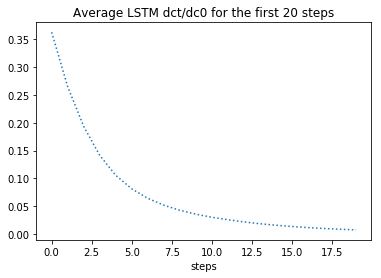

In [20]:
# Mean absolute gradients over steps
steps= [t for t in range(20)]
plt.plot(steps, dctdc0_20_agg, linestyle= 'dotted')
plt.title('Average LSTM dct/dc0 for the first 20 steps')
plt.xlabel('steps')
plt.savefig('/Users/necromancerchenmy/Desktop/honours_thesis/thesis/thesis_proposal/thesis proposal/lstm_dctdc0_20.png')


In [18]:
ds = tf.data.Dataset.from_tensor_slices((xtr_pad, ytr)).batch(100)

@tf.function
# Compute gradients
def compute_dct_dc0(t, x, c0):
    return tf.gradients(model_lstm_ct(x)[:,t,:], c0)
        
n_b = int(xtr_pad.shape[0]/ 100)  # 400 batches
n_steps = 20   # look up only the first and last 20 steps

dctdc0_last20= tf.zeros([n_b, n_steps])
for b, (x_batch_train, y_batch_train) in enumerate(ds):  # batches 0,1
    grad_batch= []   
    for t in range(input_length- n_steps, input_length):  
        # steps 0,...,19
        dctdc0_b_t = compute_dct_dc0(t, x_batch_train, c0)  # (batch_size, n_units)
        grad_t = tf.reduce_mean(abs(dctdc0_b_t[0]), [0,1]) # Scalar dctdc0 at the current batch and step
        print('step', t+1, 'of batch' ,b+1, 'done')
        grad_batch.append(grad_t)
    
    dctdc0_last20= tf.concat([dctdc0_last20, [grad_batch]], axis = 0)   

dctdc0_last20_agg= tf.reduce_mean(dctdc0_last20, 0)  # take rowmean to obtain a vector of shape (20,)
print(dctdc0_last20_agg.shape)


step 1384 of batch 1 done
step 1385 of batch 1 done
step 1386 of batch 1 done
step 1387 of batch 1 done
step 1388 of batch 1 done
step 1389 of batch 1 done
step 1390 of batch 1 done
step 1391 of batch 1 done
step 1392 of batch 1 done
step 1393 of batch 1 done
step 1394 of batch 1 done
step 1395 of batch 1 done
step 1396 of batch 1 done
step 1397 of batch 1 done
step 1398 of batch 1 done
step 1399 of batch 1 done
step 1400 of batch 1 done
step 1401 of batch 1 done
step 1402 of batch 1 done
step 1403 of batch 1 done
step 1384 of batch 2 done
step 1385 of batch 2 done
step 1386 of batch 2 done
step 1387 of batch 2 done
step 1388 of batch 2 done
step 1389 of batch 2 done
step 1390 of batch 2 done
step 1391 of batch 2 done
step 1392 of batch 2 done
step 1393 of batch 2 done
step 1394 of batch 2 done
step 1395 of batch 2 done
step 1396 of batch 2 done
step 1397 of batch 2 done
step 1398 of batch 2 done
step 1399 of batch 2 done
step 1400 of batch 2 done
step 1401 of batch 2 done
step 1402 of

step 1403 of batch 13 done
step 1384 of batch 14 done
step 1385 of batch 14 done
step 1386 of batch 14 done
step 1387 of batch 14 done
step 1388 of batch 14 done
step 1389 of batch 14 done
step 1390 of batch 14 done
step 1391 of batch 14 done
step 1392 of batch 14 done
step 1393 of batch 14 done
step 1394 of batch 14 done
step 1395 of batch 14 done
step 1396 of batch 14 done
step 1397 of batch 14 done
step 1398 of batch 14 done
step 1399 of batch 14 done
step 1400 of batch 14 done
step 1401 of batch 14 done
step 1402 of batch 14 done
step 1403 of batch 14 done
step 1384 of batch 15 done
step 1385 of batch 15 done
step 1386 of batch 15 done
step 1387 of batch 15 done
step 1388 of batch 15 done
step 1389 of batch 15 done
step 1390 of batch 15 done
step 1391 of batch 15 done
step 1392 of batch 15 done
step 1393 of batch 15 done
step 1394 of batch 15 done
step 1395 of batch 15 done
step 1396 of batch 15 done
step 1397 of batch 15 done
step 1398 of batch 15 done
step 1399 of batch 15 done
s

step 1387 of batch 29 done
step 1388 of batch 29 done
step 1389 of batch 29 done
step 1390 of batch 29 done
step 1391 of batch 29 done
step 1392 of batch 29 done
step 1393 of batch 29 done
step 1394 of batch 29 done
step 1395 of batch 29 done
step 1396 of batch 29 done
step 1397 of batch 29 done
step 1398 of batch 29 done
step 1399 of batch 29 done
step 1400 of batch 29 done
step 1401 of batch 29 done
step 1402 of batch 29 done
step 1403 of batch 29 done
step 1384 of batch 30 done
step 1385 of batch 30 done
step 1386 of batch 30 done
step 1387 of batch 30 done
step 1388 of batch 30 done
step 1389 of batch 30 done
step 1390 of batch 30 done
step 1391 of batch 30 done
step 1392 of batch 30 done
step 1393 of batch 30 done
step 1394 of batch 30 done
step 1395 of batch 30 done
step 1396 of batch 30 done
step 1397 of batch 30 done
step 1398 of batch 30 done
step 1399 of batch 30 done
step 1400 of batch 30 done
step 1401 of batch 30 done
step 1402 of batch 30 done
step 1403 of batch 30 done
s

step 1391 of batch 44 done
step 1392 of batch 44 done
step 1393 of batch 44 done
step 1394 of batch 44 done
step 1395 of batch 44 done
step 1396 of batch 44 done
step 1397 of batch 44 done
step 1398 of batch 44 done
step 1399 of batch 44 done
step 1400 of batch 44 done
step 1401 of batch 44 done
step 1402 of batch 44 done
step 1403 of batch 44 done
step 1384 of batch 45 done
step 1385 of batch 45 done
step 1386 of batch 45 done
step 1387 of batch 45 done
step 1388 of batch 45 done
step 1389 of batch 45 done
step 1390 of batch 45 done
step 1391 of batch 45 done
step 1392 of batch 45 done
step 1393 of batch 45 done
step 1394 of batch 45 done
step 1395 of batch 45 done
step 1396 of batch 45 done
step 1397 of batch 45 done
step 1398 of batch 45 done
step 1399 of batch 45 done
step 1400 of batch 45 done
step 1401 of batch 45 done
step 1402 of batch 45 done
step 1403 of batch 45 done
step 1384 of batch 46 done
step 1385 of batch 46 done
step 1386 of batch 46 done
step 1387 of batch 46 done
s

step 1395 of batch 59 done
step 1396 of batch 59 done
step 1397 of batch 59 done
step 1398 of batch 59 done
step 1399 of batch 59 done
step 1400 of batch 59 done
step 1401 of batch 59 done
step 1402 of batch 59 done
step 1403 of batch 59 done
step 1384 of batch 60 done
step 1385 of batch 60 done
step 1386 of batch 60 done
step 1387 of batch 60 done
step 1388 of batch 60 done
step 1389 of batch 60 done
step 1390 of batch 60 done
step 1391 of batch 60 done
step 1392 of batch 60 done
step 1393 of batch 60 done
step 1394 of batch 60 done
step 1395 of batch 60 done
step 1396 of batch 60 done
step 1397 of batch 60 done
step 1398 of batch 60 done
step 1399 of batch 60 done
step 1400 of batch 60 done
step 1401 of batch 60 done
step 1402 of batch 60 done
step 1403 of batch 60 done
step 1384 of batch 61 done
step 1385 of batch 61 done
step 1386 of batch 61 done
step 1387 of batch 61 done
step 1388 of batch 61 done
step 1389 of batch 61 done
step 1390 of batch 61 done
step 1391 of batch 61 done
s

step 1399 of batch 74 done
step 1400 of batch 74 done
step 1401 of batch 74 done
step 1402 of batch 74 done
step 1403 of batch 74 done
step 1384 of batch 75 done
step 1385 of batch 75 done
step 1386 of batch 75 done
step 1387 of batch 75 done
step 1388 of batch 75 done
step 1389 of batch 75 done
step 1390 of batch 75 done
step 1391 of batch 75 done
step 1392 of batch 75 done
step 1393 of batch 75 done
step 1394 of batch 75 done
step 1395 of batch 75 done
step 1396 of batch 75 done
step 1397 of batch 75 done
step 1398 of batch 75 done
step 1399 of batch 75 done
step 1400 of batch 75 done
step 1401 of batch 75 done
step 1402 of batch 75 done
step 1403 of batch 75 done
step 1384 of batch 76 done
step 1385 of batch 76 done
step 1386 of batch 76 done
step 1387 of batch 76 done
step 1388 of batch 76 done
step 1389 of batch 76 done
step 1390 of batch 76 done
step 1391 of batch 76 done
step 1392 of batch 76 done
step 1393 of batch 76 done
step 1394 of batch 76 done
step 1395 of batch 76 done
s

step 1403 of batch 89 done
step 1384 of batch 90 done
step 1385 of batch 90 done
step 1386 of batch 90 done
step 1387 of batch 90 done
step 1388 of batch 90 done
step 1389 of batch 90 done
step 1390 of batch 90 done
step 1391 of batch 90 done
step 1392 of batch 90 done
step 1393 of batch 90 done
step 1394 of batch 90 done
step 1395 of batch 90 done
step 1396 of batch 90 done
step 1397 of batch 90 done
step 1398 of batch 90 done
step 1399 of batch 90 done
step 1400 of batch 90 done
step 1401 of batch 90 done
step 1402 of batch 90 done
step 1403 of batch 90 done
step 1384 of batch 91 done
step 1385 of batch 91 done
step 1386 of batch 91 done
step 1387 of batch 91 done
step 1388 of batch 91 done
step 1389 of batch 91 done
step 1390 of batch 91 done
step 1391 of batch 91 done
step 1392 of batch 91 done
step 1393 of batch 91 done
step 1394 of batch 91 done
step 1395 of batch 91 done
step 1396 of batch 91 done
step 1397 of batch 91 done
step 1398 of batch 91 done
step 1399 of batch 91 done
s

step 1403 of batch 104 done
step 1384 of batch 105 done
step 1385 of batch 105 done
step 1386 of batch 105 done
step 1387 of batch 105 done
step 1388 of batch 105 done
step 1389 of batch 105 done
step 1390 of batch 105 done
step 1391 of batch 105 done
step 1392 of batch 105 done
step 1393 of batch 105 done
step 1394 of batch 105 done
step 1395 of batch 105 done
step 1396 of batch 105 done
step 1397 of batch 105 done
step 1398 of batch 105 done
step 1399 of batch 105 done
step 1400 of batch 105 done
step 1401 of batch 105 done
step 1402 of batch 105 done
step 1403 of batch 105 done
step 1384 of batch 106 done
step 1385 of batch 106 done
step 1386 of batch 106 done
step 1387 of batch 106 done
step 1388 of batch 106 done
step 1389 of batch 106 done
step 1390 of batch 106 done
step 1391 of batch 106 done
step 1392 of batch 106 done
step 1393 of batch 106 done
step 1394 of batch 106 done
step 1395 of batch 106 done
step 1396 of batch 106 done
step 1397 of batch 106 done
step 1398 of batch 1

step 1396 of batch 119 done
step 1397 of batch 119 done
step 1398 of batch 119 done
step 1399 of batch 119 done
step 1400 of batch 119 done
step 1401 of batch 119 done
step 1402 of batch 119 done
step 1403 of batch 119 done
step 1384 of batch 120 done
step 1385 of batch 120 done
step 1386 of batch 120 done
step 1387 of batch 120 done
step 1388 of batch 120 done
step 1389 of batch 120 done
step 1390 of batch 120 done
step 1391 of batch 120 done
step 1392 of batch 120 done
step 1393 of batch 120 done
step 1394 of batch 120 done
step 1395 of batch 120 done
step 1396 of batch 120 done
step 1397 of batch 120 done
step 1398 of batch 120 done
step 1399 of batch 120 done
step 1400 of batch 120 done
step 1401 of batch 120 done
step 1402 of batch 120 done
step 1403 of batch 120 done
step 1384 of batch 121 done
step 1385 of batch 121 done
step 1386 of batch 121 done
step 1387 of batch 121 done
step 1388 of batch 121 done
step 1389 of batch 121 done
step 1390 of batch 121 done
step 1391 of batch 1

step 1389 of batch 134 done
step 1390 of batch 134 done
step 1391 of batch 134 done
step 1392 of batch 134 done
step 1393 of batch 134 done
step 1394 of batch 134 done
step 1395 of batch 134 done
step 1396 of batch 134 done
step 1397 of batch 134 done
step 1398 of batch 134 done
step 1399 of batch 134 done
step 1400 of batch 134 done
step 1401 of batch 134 done
step 1402 of batch 134 done
step 1403 of batch 134 done
step 1384 of batch 135 done
step 1385 of batch 135 done
step 1386 of batch 135 done
step 1387 of batch 135 done
step 1388 of batch 135 done
step 1389 of batch 135 done
step 1390 of batch 135 done
step 1391 of batch 135 done
step 1392 of batch 135 done
step 1393 of batch 135 done
step 1394 of batch 135 done
step 1395 of batch 135 done
step 1396 of batch 135 done
step 1397 of batch 135 done
step 1398 of batch 135 done
step 1399 of batch 135 done
step 1400 of batch 135 done
step 1401 of batch 135 done
step 1402 of batch 135 done
step 1403 of batch 135 done
step 1384 of batch 1

step 1402 of batch 148 done
step 1403 of batch 148 done
step 1384 of batch 149 done
step 1385 of batch 149 done
step 1386 of batch 149 done
step 1387 of batch 149 done
step 1388 of batch 149 done
step 1389 of batch 149 done
step 1390 of batch 149 done
step 1391 of batch 149 done
step 1392 of batch 149 done
step 1393 of batch 149 done
step 1394 of batch 149 done
step 1395 of batch 149 done
step 1396 of batch 149 done
step 1397 of batch 149 done
step 1398 of batch 149 done
step 1399 of batch 149 done
step 1400 of batch 149 done
step 1401 of batch 149 done
step 1402 of batch 149 done
step 1403 of batch 149 done
step 1384 of batch 150 done
step 1385 of batch 150 done
step 1386 of batch 150 done
step 1387 of batch 150 done
step 1388 of batch 150 done
step 1389 of batch 150 done
step 1390 of batch 150 done
step 1391 of batch 150 done
step 1392 of batch 150 done
step 1393 of batch 150 done
step 1394 of batch 150 done
step 1395 of batch 150 done
step 1396 of batch 150 done
step 1397 of batch 1

step 1395 of batch 163 done
step 1396 of batch 163 done
step 1397 of batch 163 done
step 1398 of batch 163 done
step 1399 of batch 163 done
step 1400 of batch 163 done
step 1401 of batch 163 done
step 1402 of batch 163 done
step 1403 of batch 163 done
step 1384 of batch 164 done
step 1385 of batch 164 done
step 1386 of batch 164 done
step 1387 of batch 164 done
step 1388 of batch 164 done
step 1389 of batch 164 done
step 1390 of batch 164 done
step 1391 of batch 164 done
step 1392 of batch 164 done
step 1393 of batch 164 done
step 1394 of batch 164 done
step 1395 of batch 164 done
step 1396 of batch 164 done
step 1397 of batch 164 done
step 1398 of batch 164 done
step 1399 of batch 164 done
step 1400 of batch 164 done
step 1401 of batch 164 done
step 1402 of batch 164 done
step 1403 of batch 164 done
step 1384 of batch 165 done
step 1385 of batch 165 done
step 1386 of batch 165 done
step 1387 of batch 165 done
step 1388 of batch 165 done
step 1389 of batch 165 done
step 1390 of batch 1

step 1388 of batch 178 done
step 1389 of batch 178 done
step 1390 of batch 178 done
step 1391 of batch 178 done
step 1392 of batch 178 done
step 1393 of batch 178 done
step 1394 of batch 178 done
step 1395 of batch 178 done
step 1396 of batch 178 done
step 1397 of batch 178 done
step 1398 of batch 178 done
step 1399 of batch 178 done
step 1400 of batch 178 done
step 1401 of batch 178 done
step 1402 of batch 178 done
step 1403 of batch 178 done
step 1384 of batch 179 done
step 1385 of batch 179 done
step 1386 of batch 179 done
step 1387 of batch 179 done
step 1388 of batch 179 done
step 1389 of batch 179 done
step 1390 of batch 179 done
step 1391 of batch 179 done
step 1392 of batch 179 done
step 1393 of batch 179 done
step 1394 of batch 179 done
step 1395 of batch 179 done
step 1396 of batch 179 done
step 1397 of batch 179 done
step 1398 of batch 179 done
step 1399 of batch 179 done
step 1400 of batch 179 done
step 1401 of batch 179 done
step 1402 of batch 179 done
step 1403 of batch 1

step 1401 of batch 192 done
step 1402 of batch 192 done
step 1403 of batch 192 done
step 1384 of batch 193 done
step 1385 of batch 193 done
step 1386 of batch 193 done
step 1387 of batch 193 done
step 1388 of batch 193 done
step 1389 of batch 193 done
step 1390 of batch 193 done
step 1391 of batch 193 done
step 1392 of batch 193 done
step 1393 of batch 193 done
step 1394 of batch 193 done
step 1395 of batch 193 done
step 1396 of batch 193 done
step 1397 of batch 193 done
step 1398 of batch 193 done
step 1399 of batch 193 done
step 1400 of batch 193 done
step 1401 of batch 193 done
step 1402 of batch 193 done
step 1403 of batch 193 done
step 1384 of batch 194 done
step 1385 of batch 194 done
step 1386 of batch 194 done
step 1387 of batch 194 done
step 1388 of batch 194 done
step 1389 of batch 194 done
step 1390 of batch 194 done
step 1391 of batch 194 done
step 1392 of batch 194 done
step 1393 of batch 194 done
step 1394 of batch 194 done
step 1395 of batch 194 done
step 1396 of batch 1

step 1394 of batch 207 done
step 1395 of batch 207 done
step 1396 of batch 207 done
step 1397 of batch 207 done
step 1398 of batch 207 done
step 1399 of batch 207 done
step 1400 of batch 207 done
step 1401 of batch 207 done
step 1402 of batch 207 done
step 1403 of batch 207 done
step 1384 of batch 208 done
step 1385 of batch 208 done
step 1386 of batch 208 done
step 1387 of batch 208 done
step 1388 of batch 208 done
step 1389 of batch 208 done
step 1390 of batch 208 done
step 1391 of batch 208 done
step 1392 of batch 208 done
step 1393 of batch 208 done
step 1394 of batch 208 done
step 1395 of batch 208 done
step 1396 of batch 208 done
step 1397 of batch 208 done
step 1398 of batch 208 done
step 1399 of batch 208 done
step 1400 of batch 208 done
step 1401 of batch 208 done
step 1402 of batch 208 done
step 1403 of batch 208 done
step 1384 of batch 209 done
step 1385 of batch 209 done
step 1386 of batch 209 done
step 1387 of batch 209 done
step 1388 of batch 209 done
step 1389 of batch 2

step 1387 of batch 222 done
step 1388 of batch 222 done
step 1389 of batch 222 done
step 1390 of batch 222 done
step 1391 of batch 222 done
step 1392 of batch 222 done
step 1393 of batch 222 done
step 1394 of batch 222 done
step 1395 of batch 222 done
step 1396 of batch 222 done
step 1397 of batch 222 done
step 1398 of batch 222 done
step 1399 of batch 222 done
step 1400 of batch 222 done
step 1401 of batch 222 done
step 1402 of batch 222 done
step 1403 of batch 222 done
step 1384 of batch 223 done
step 1385 of batch 223 done
step 1386 of batch 223 done
step 1387 of batch 223 done
step 1388 of batch 223 done
step 1389 of batch 223 done
step 1390 of batch 223 done
step 1391 of batch 223 done
step 1392 of batch 223 done
step 1393 of batch 223 done
step 1394 of batch 223 done
step 1395 of batch 223 done
step 1396 of batch 223 done
step 1397 of batch 223 done
step 1398 of batch 223 done
step 1399 of batch 223 done
step 1400 of batch 223 done
step 1401 of batch 223 done
step 1402 of batch 2

step 1400 of batch 236 done
step 1401 of batch 236 done
step 1402 of batch 236 done
step 1403 of batch 236 done
step 1384 of batch 237 done
step 1385 of batch 237 done
step 1386 of batch 237 done
step 1387 of batch 237 done
step 1388 of batch 237 done
step 1389 of batch 237 done
step 1390 of batch 237 done
step 1391 of batch 237 done
step 1392 of batch 237 done
step 1393 of batch 237 done
step 1394 of batch 237 done
step 1395 of batch 237 done
step 1396 of batch 237 done
step 1397 of batch 237 done
step 1398 of batch 237 done
step 1399 of batch 237 done
step 1400 of batch 237 done
step 1401 of batch 237 done
step 1402 of batch 237 done
step 1403 of batch 237 done
step 1384 of batch 238 done
step 1385 of batch 238 done
step 1386 of batch 238 done
step 1387 of batch 238 done
step 1388 of batch 238 done
step 1389 of batch 238 done
step 1390 of batch 238 done
step 1391 of batch 238 done
step 1392 of batch 238 done
step 1393 of batch 238 done
step 1394 of batch 238 done
step 1395 of batch 2

step 1393 of batch 251 done
step 1394 of batch 251 done
step 1395 of batch 251 done
step 1396 of batch 251 done
step 1397 of batch 251 done
step 1398 of batch 251 done
step 1399 of batch 251 done
step 1400 of batch 251 done
step 1401 of batch 251 done
step 1402 of batch 251 done
step 1403 of batch 251 done
step 1384 of batch 252 done
step 1385 of batch 252 done
step 1386 of batch 252 done
step 1387 of batch 252 done
step 1388 of batch 252 done
step 1389 of batch 252 done
step 1390 of batch 252 done
step 1391 of batch 252 done
step 1392 of batch 252 done
step 1393 of batch 252 done
step 1394 of batch 252 done
step 1395 of batch 252 done
step 1396 of batch 252 done
step 1397 of batch 252 done
step 1398 of batch 252 done
step 1399 of batch 252 done
step 1400 of batch 252 done
step 1401 of batch 252 done
step 1402 of batch 252 done
step 1403 of batch 252 done
step 1384 of batch 253 done
step 1385 of batch 253 done
step 1386 of batch 253 done
step 1387 of batch 253 done
step 1388 of batch 2

step 1386 of batch 266 done
step 1387 of batch 266 done
step 1388 of batch 266 done
step 1389 of batch 266 done
step 1390 of batch 266 done
step 1391 of batch 266 done
step 1392 of batch 266 done
step 1393 of batch 266 done
step 1394 of batch 266 done
step 1395 of batch 266 done
step 1396 of batch 266 done
step 1397 of batch 266 done
step 1398 of batch 266 done
step 1399 of batch 266 done
step 1400 of batch 266 done
step 1401 of batch 266 done
step 1402 of batch 266 done
step 1403 of batch 266 done
step 1384 of batch 267 done
step 1385 of batch 267 done
step 1386 of batch 267 done
step 1387 of batch 267 done
step 1388 of batch 267 done
step 1389 of batch 267 done
step 1390 of batch 267 done
step 1391 of batch 267 done
step 1392 of batch 267 done
step 1393 of batch 267 done
step 1394 of batch 267 done
step 1395 of batch 267 done
step 1396 of batch 267 done
step 1397 of batch 267 done
step 1398 of batch 267 done
step 1399 of batch 267 done
step 1400 of batch 267 done
step 1401 of batch 2

step 1399 of batch 280 done
step 1400 of batch 280 done
step 1401 of batch 280 done
step 1402 of batch 280 done
step 1403 of batch 280 done
step 1384 of batch 281 done
step 1385 of batch 281 done
step 1386 of batch 281 done
step 1387 of batch 281 done
step 1388 of batch 281 done
step 1389 of batch 281 done
step 1390 of batch 281 done
step 1391 of batch 281 done
step 1392 of batch 281 done
step 1393 of batch 281 done
step 1394 of batch 281 done
step 1395 of batch 281 done
step 1396 of batch 281 done
step 1397 of batch 281 done
step 1398 of batch 281 done
step 1399 of batch 281 done
step 1400 of batch 281 done
step 1401 of batch 281 done
step 1402 of batch 281 done
step 1403 of batch 281 done
step 1384 of batch 282 done
step 1385 of batch 282 done
step 1386 of batch 282 done
step 1387 of batch 282 done
step 1388 of batch 282 done
step 1389 of batch 282 done
step 1390 of batch 282 done
step 1391 of batch 282 done
step 1392 of batch 282 done
step 1393 of batch 282 done
step 1394 of batch 2

step 1392 of batch 295 done
step 1393 of batch 295 done
step 1394 of batch 295 done
step 1395 of batch 295 done
step 1396 of batch 295 done
step 1397 of batch 295 done
step 1398 of batch 295 done
step 1399 of batch 295 done
step 1400 of batch 295 done
step 1401 of batch 295 done
step 1402 of batch 295 done
step 1403 of batch 295 done
step 1384 of batch 296 done
step 1385 of batch 296 done
step 1386 of batch 296 done
step 1387 of batch 296 done
step 1388 of batch 296 done
step 1389 of batch 296 done
step 1390 of batch 296 done
step 1391 of batch 296 done
step 1392 of batch 296 done
step 1393 of batch 296 done
step 1394 of batch 296 done
step 1395 of batch 296 done
step 1396 of batch 296 done
step 1397 of batch 296 done
step 1398 of batch 296 done
step 1399 of batch 296 done
step 1400 of batch 296 done
step 1401 of batch 296 done
step 1402 of batch 296 done
step 1403 of batch 296 done
step 1384 of batch 297 done
step 1385 of batch 297 done
step 1386 of batch 297 done
step 1387 of batch 2

step 1385 of batch 310 done
step 1386 of batch 310 done
step 1387 of batch 310 done
step 1388 of batch 310 done
step 1389 of batch 310 done
step 1390 of batch 310 done
step 1391 of batch 310 done
step 1392 of batch 310 done
step 1393 of batch 310 done
step 1394 of batch 310 done
step 1395 of batch 310 done
step 1396 of batch 310 done
step 1397 of batch 310 done
step 1398 of batch 310 done
step 1399 of batch 310 done
step 1400 of batch 310 done
step 1401 of batch 310 done
step 1402 of batch 310 done
step 1403 of batch 310 done
step 1384 of batch 311 done
step 1385 of batch 311 done
step 1386 of batch 311 done
step 1387 of batch 311 done
step 1388 of batch 311 done
step 1389 of batch 311 done
step 1390 of batch 311 done
step 1391 of batch 311 done
step 1392 of batch 311 done
step 1393 of batch 311 done
step 1394 of batch 311 done
step 1395 of batch 311 done
step 1396 of batch 311 done
step 1397 of batch 311 done
step 1398 of batch 311 done
step 1399 of batch 311 done
step 1400 of batch 3

step 1398 of batch 324 done
step 1399 of batch 324 done
step 1400 of batch 324 done
step 1401 of batch 324 done
step 1402 of batch 324 done
step 1403 of batch 324 done
step 1384 of batch 325 done
step 1385 of batch 325 done
step 1386 of batch 325 done
step 1387 of batch 325 done
step 1388 of batch 325 done
step 1389 of batch 325 done
step 1390 of batch 325 done
step 1391 of batch 325 done
step 1392 of batch 325 done
step 1393 of batch 325 done
step 1394 of batch 325 done
step 1395 of batch 325 done
step 1396 of batch 325 done
step 1397 of batch 325 done
step 1398 of batch 325 done
step 1399 of batch 325 done
step 1400 of batch 325 done
step 1401 of batch 325 done
step 1402 of batch 325 done
step 1403 of batch 325 done
step 1384 of batch 326 done
step 1385 of batch 326 done
step 1386 of batch 326 done
step 1387 of batch 326 done
step 1388 of batch 326 done
step 1389 of batch 326 done
step 1390 of batch 326 done
step 1391 of batch 326 done
step 1392 of batch 326 done
step 1393 of batch 3

step 1391 of batch 339 done
step 1392 of batch 339 done
step 1393 of batch 339 done
step 1394 of batch 339 done
step 1395 of batch 339 done
step 1396 of batch 339 done
step 1397 of batch 339 done
step 1398 of batch 339 done
step 1399 of batch 339 done
step 1400 of batch 339 done
step 1401 of batch 339 done
step 1402 of batch 339 done
step 1403 of batch 339 done
step 1384 of batch 340 done
step 1385 of batch 340 done
step 1386 of batch 340 done
step 1387 of batch 340 done
step 1388 of batch 340 done
step 1389 of batch 340 done
step 1390 of batch 340 done
step 1391 of batch 340 done
step 1392 of batch 340 done
step 1393 of batch 340 done
step 1394 of batch 340 done
step 1395 of batch 340 done
step 1396 of batch 340 done
step 1397 of batch 340 done
step 1398 of batch 340 done
step 1399 of batch 340 done
step 1400 of batch 340 done
step 1401 of batch 340 done
step 1402 of batch 340 done
step 1403 of batch 340 done
step 1384 of batch 341 done
step 1385 of batch 341 done
step 1386 of batch 3

step 1384 of batch 354 done
step 1385 of batch 354 done
step 1386 of batch 354 done
step 1387 of batch 354 done
step 1388 of batch 354 done
step 1389 of batch 354 done
step 1390 of batch 354 done
step 1391 of batch 354 done
step 1392 of batch 354 done
step 1393 of batch 354 done
step 1394 of batch 354 done
step 1395 of batch 354 done
step 1396 of batch 354 done
step 1397 of batch 354 done
step 1398 of batch 354 done
step 1399 of batch 354 done
step 1400 of batch 354 done
step 1401 of batch 354 done
step 1402 of batch 354 done
step 1403 of batch 354 done
step 1384 of batch 355 done
step 1385 of batch 355 done
step 1386 of batch 355 done
step 1387 of batch 355 done
step 1388 of batch 355 done
step 1389 of batch 355 done
step 1390 of batch 355 done
step 1391 of batch 355 done
step 1392 of batch 355 done
step 1393 of batch 355 done
step 1394 of batch 355 done
step 1395 of batch 355 done
step 1396 of batch 355 done
step 1397 of batch 355 done
step 1398 of batch 355 done
step 1399 of batch 3

step 1397 of batch 368 done
step 1398 of batch 368 done
step 1399 of batch 368 done
step 1400 of batch 368 done
step 1401 of batch 368 done
step 1402 of batch 368 done
step 1403 of batch 368 done
step 1384 of batch 369 done
step 1385 of batch 369 done
step 1386 of batch 369 done
step 1387 of batch 369 done
step 1388 of batch 369 done
step 1389 of batch 369 done
step 1390 of batch 369 done
step 1391 of batch 369 done
step 1392 of batch 369 done
step 1393 of batch 369 done
step 1394 of batch 369 done
step 1395 of batch 369 done
step 1396 of batch 369 done
step 1397 of batch 369 done
step 1398 of batch 369 done
step 1399 of batch 369 done
step 1400 of batch 369 done
step 1401 of batch 369 done
step 1402 of batch 369 done
step 1403 of batch 369 done
step 1384 of batch 370 done
step 1385 of batch 370 done
step 1386 of batch 370 done
step 1387 of batch 370 done
step 1388 of batch 370 done
step 1389 of batch 370 done
step 1390 of batch 370 done
step 1391 of batch 370 done
step 1392 of batch 3

step 1390 of batch 383 done
step 1391 of batch 383 done
step 1392 of batch 383 done
step 1393 of batch 383 done
step 1394 of batch 383 done
step 1395 of batch 383 done
step 1396 of batch 383 done
step 1397 of batch 383 done
step 1398 of batch 383 done
step 1399 of batch 383 done
step 1400 of batch 383 done
step 1401 of batch 383 done
step 1402 of batch 383 done
step 1403 of batch 383 done
step 1384 of batch 384 done
step 1385 of batch 384 done
step 1386 of batch 384 done
step 1387 of batch 384 done
step 1388 of batch 384 done
step 1389 of batch 384 done
step 1390 of batch 384 done
step 1391 of batch 384 done
step 1392 of batch 384 done
step 1393 of batch 384 done
step 1394 of batch 384 done
step 1395 of batch 384 done
step 1396 of batch 384 done
step 1397 of batch 384 done
step 1398 of batch 384 done
step 1399 of batch 384 done
step 1400 of batch 384 done
step 1401 of batch 384 done
step 1402 of batch 384 done
step 1403 of batch 384 done
step 1384 of batch 385 done
step 1385 of batch 3

step 1403 of batch 397 done
step 1384 of batch 398 done
step 1385 of batch 398 done
step 1386 of batch 398 done
step 1387 of batch 398 done
step 1388 of batch 398 done
step 1389 of batch 398 done
step 1390 of batch 398 done
step 1391 of batch 398 done
step 1392 of batch 398 done
step 1393 of batch 398 done
step 1394 of batch 398 done
step 1395 of batch 398 done
step 1396 of batch 398 done
step 1397 of batch 398 done
step 1398 of batch 398 done
step 1399 of batch 398 done
step 1400 of batch 398 done
step 1401 of batch 398 done
step 1402 of batch 398 done
step 1403 of batch 398 done
step 1384 of batch 399 done
step 1385 of batch 399 done
step 1386 of batch 399 done
step 1387 of batch 399 done
step 1388 of batch 399 done
step 1389 of batch 399 done
step 1390 of batch 399 done
step 1391 of batch 399 done
step 1392 of batch 399 done
step 1393 of batch 399 done
step 1394 of batch 399 done
step 1395 of batch 399 done
step 1396 of batch 399 done
step 1397 of batch 399 done
step 1398 of batch 3

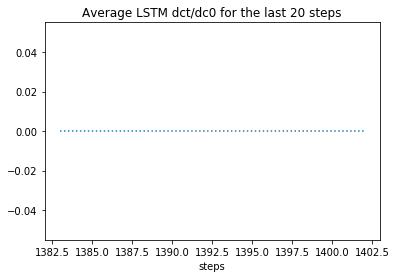

In [19]:
# Mean absolute gradients over steps
steps= [t for t in range(input_length- 20, input_length)]
plt.plot(steps, dctdc0_last20_agg, linestyle= 'dotted')
plt.title('Average LSTM dct/dc0 for the last 20 steps')
plt.xlabel('steps')
plt.savefig('/Users/necromancerchenmy/Desktop/honours_thesis/thesis/thesis_proposal/thesis proposal/lstm_dctdc0_20.png')
